In [1]:
import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd

import cPickle as pkl
from scipy import stats as spstats

from pipeline.python.classifications import responsivity_stats as resp
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import get_dataset_stats as ds
from pipeline.python.utils import natural_keys, label_figure, convert_range

from pipeline.python.retinotopy import convert_coords as cc


/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py"

In [2]:
%matplotlib notebook

# Set output dir


In [3]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Set dataset parameters

In [4]:
rootdir = '/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
response_type = 'dff'
traceid='traces001'
trace_type= 'corrected'
responsive_test = 'ROC'
fit_thr=0.5

In [5]:
fit_desc = fitrf.get_fit_desc(response_type=response_type)
print(fit_desc)

data_desc = '-'.join([traceid, trace_type, response_type, responsive_test])

data_identifier = '|'.join([data_desc, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print(data_identifier)

fit-2dgaus_dff-no-cutoff
traces001-corrected-dff-ROC|fit-2dgaus_dff-no-cutoff-thr-0.50


# Create output dir for specified RF fits

In [6]:
rfdir = os.path.join(aggregate_dir, 'rfs', fit_desc)
if not os.path.exists(rfdir):
    os.makedirs(rfdir)

# Get summary of all datasets

In [7]:
dataset_info_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(dataset_info_fpath):
    with open(dataset_info_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = ds.aggregate_session_info()

In [8]:
sdata.head()

,animalid,experiment,fov,session,visual_area,exp_no,animal_no
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,3,4
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1,4
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,0,4
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,2,4
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,3,4


In [9]:
sdata['experiment'].unique()

array(['rfs', 'gratings', 'blobs', 'retino', 'rfs10'], dtype=object)

# Select datasets - no reps

IGNORE THESE:
V1:  JC076-20190501, JC083-20190510
    - if blobs & rfs only: ignore JC083_20190511, else ALSO ignore: 20190507-JC083
Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if blobs & rfs only: ignore JC078-2019513, else ALSO ignore: JC078-20190430
    - if blobs & rfs only: ignore JC083-20190512, else ALSO ignore: JC083-20190508
Li:  JC076-20190422, JC099-20190509, JC091-20190607, JC091-20190606
    

In [132]:
always_exclude = ['JC076-20190501', 'JC083-20190510', 
                  'JC078-20190426', 'JC078-20190509', 'JC080-20190506', 'JC083-20190517',
                 'JC076-20190422', 'JC099-20190509', 'JC091-20190607', 'JC091-20190606']

also_exclude = ['JC083-20190511',
                'JC078-2019513', 'JC083-20190512']

excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
print(len(excluded_sessions))

13


In [133]:
rfdata.head()

,index,animalid,experiment,fov,session,visual_area,exp_no,animal_no,path
0,0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,3,4,/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0...
1,4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,3,4,/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0...
2,8,JC091,rfs,FOV1_zoom2p0x,20190627,Lm,3,7,/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0...
3,16,JC091,rfs10,FOV1_zoom2p0x,20190614,Li,4,7,/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0...
4,24,JC091,rfs,FOV1_zoom2p0x,20190602,Li,3,7,/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0...


In [134]:
excluded_sessions

['JC076-20190501',
 'JC083-20190510',
 'JC078-20190426',
 'JC078-20190509',
 'JC080-20190506',
 'JC083-20190517',
 'JC076-20190422',
 'JC099-20190509',
 'JC091-20190607',
 'JC091-20190606',
 'JC083-20190511',
 'JC078-2019513',
 'JC083-20190512']

In [135]:
rfdata = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
print rfdata.shape
for skey in excluded_sessions:
    animalid, session = skey.split('-')
    drop_ixs = rfdata[(rfdata['animalid']==animalid) & (rfdata['session']==session)].index.tolist()
    rfdata = rfdata.drop(drop_ixs)
print rfdata.shape

(40, 7)
(30, 7)


In [136]:
rfdata

,animalid,experiment,fov,session,visual_area,exp_no,animal_no
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,3,4
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,3,4
8,JC091,rfs,FOV1_zoom2p0x,20190627,Lm,3,7
16,JC091,rfs10,FOV1_zoom2p0x,20190614,Li,4,7
24,JC091,rfs,FOV1_zoom2p0x,20190602,Li,3,7
25,JC091,rfs10,FOV1_zoom2p0x,20190602,Li,4,7
29,JC085,rfs,FOV1_zoom2p0x,20190622,V1,3,5
30,JC085,rfs10,FOV1_zoom2p0x,20190622,V1,4,5
34,JC090,rfs10,FOV1_zoom2p0x,20190605,Li,4,6
38,JC099,rfs10,FOV1_zoom2p0x,20190612,Li,4,9


# Check for any datasets that need RF fits

In [137]:
def get_rfdata(sdata, fit_desc=None, excluded_sessions=[]):
    assert fit_desc is not None, "No fit-desc specified!"
    
    rfdata = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
    for skey in excluded_sessions:
        animalid, session = skey.split('-')
        drop_ixs = rfdata[(rfdata['animalid']==animalid) & (rfdata['session']==session)].index.tolist()
        rfdata= rfdata.drop(drop_ixs)
            
    fit_these = []
    dpaths = {}
    unknown = []
    for (visual_area, animalid, session, fov), g in rfdata.groupby(['visual_area', 'animalid', 'session', 'fov']): #animalid in rfdata['animalid'].unique():
        skey = '-'.join([animalid, session])
        if skey in excluded_sessions:
            continue

        rfruns = g['experiment'].unique()

        for rfname in rfruns:
            if int(session) < 20190511:
                fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                            'combined_gratings*', 'traces', '%s*' % traceid, 
                                            'receptive_fields', fit_desc, 'fit_results.pkl'))
            else:
                fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                            'combined_%s_*' % rfname, 'traces', '%s*' % traceid, 
                                            'receptive_fields', fit_desc, 'fit_results.pkl'))
            if len(fpath) > 0:
                assert len(fpath)==1, "TOo many paths: %s" % str(fpath)
                dpaths['-'.join([animalid, session, fov, rfname])] = fpath[0]
                
            elif len(f) == 0:
                fit_these.append((animalid, session, fov, rfname))
            else:
                unknown.append((animalid, session, fov, rfname))
    nostats = []
    for (animalid, session, fov, run_name) in fit_these:
        nostats = resp.visualize_session_stats(animalid, session, fov, altdir=aggregate_session_dir, create_new=True)

    
    print ("N dpaths: %i, N unfit: %i, N unknown: %i" % (len(dpaths), len(fit_these), len(unknown)))
    print("N datasets included: %i, N sessions excluded: %i" % (rfdata.shape[0], len(excluded_sessions)))
    #assert (len(dpaths) + len(fit_these) + len(unknown)) == rfdata.shape[0] - len(excluded_sessions), "There are dsets unaccounted for..."
    
    rfdata = rfdata.reset_index()
    fillpaths = ['' for _ in range(rfdata.shape[0])]
    for skey, fpath in dpaths.items():
        animalid, session, fov, rfname = skey.split('-')
        df_ix = rfdata[ (rfdata['animalid']==animalid) \
                           & (rfdata['session']==session) \
                           & (rfdata['fov']==fov) \
                           & (rfdata['experiment']==rfname)].index.tolist()[0]
        fillpaths[df_ix] = fpath
        
    rfdata['path'] = fillpaths
    
    return rfdata, nostats

In [138]:
exclude_repeats=True
if exclude_repeats:
    rfdata, nostats = get_rfdata(sdata, fit_desc=fit_desc, excluded_sessions=excluded_sessions)
else:
    rfdata, nostats = get_rfdata(sdata, fit_desc=fit_desc, excluded_sessions=[])
    print(nostats)

N dpaths: 30, N unfit: 0, N unknown: 0
N datasets included: 30, N sessions excluded: 13


# Get RF dataframe for all datasets

In [139]:
rfdata

,index,animalid,experiment,fov,session,visual_area,exp_no,animal_no,path
0,0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,3,4,/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0...
1,4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,3,4,/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0...
2,8,JC091,rfs,FOV1_zoom2p0x,20190627,Lm,3,7,/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0...
3,16,JC091,rfs10,FOV1_zoom2p0x,20190614,Li,4,7,/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0...
4,24,JC091,rfs,FOV1_zoom2p0x,20190602,Li,3,7,/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0...
5,25,JC091,rfs10,FOV1_zoom2p0x,20190602,Li,4,7,/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0...
6,29,JC085,rfs,FOV1_zoom2p0x,20190622,V1,3,5,/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0...
7,30,JC085,rfs10,FOV1_zoom2p0x,20190622,V1,4,5,/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0...
8,34,JC090,rfs10,FOV1_zoom2p0x,20190605,Li,4,6,/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0...
9,38,JC099,rfs10,FOV1_zoom2p0x,20190612,Li,4,9,/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0...


In [197]:
def aggregate_rf_data(rfdata, fit_thr=0.5, sigma_scale=2.35):
    df_list = []

    for (visual_area, animalid, session, fov), g in rfdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
        skey = '-'.join([animalid, session, fov])
        rfruns = g['experiment'].unique()
        print ("%s - %s: %i rf experiments." % (visual_area, skey, len(rfruns)))
        if 'rfs10' in rfruns:
            rfname = 'rfs10'
        else:
            rfname = 'rfs'
        fpath = g[g['experiment']==rfname]['path'].values[0]

        with open(fpath,'rb') as f:
            rfits = pkl.load(f)

        roi_list = [r for r, res in rfits['fit_results'].items() if res['fit_r']['r2'] >= fit_thr]
        fitdf = fitrf.rfits_to_df(rfits['fit_results'], 
                                row_vals=rfits['row_vals'],
                                col_vals=rfits['col_vals'],
                                roi_list=sorted(roi_list))
        nsamples = fitdf.shape[0]
        fitdf['cell'] = [int(i) for i in fitdf.index.tolist()]
        fitdf['animalid'] = [animalid for _ in range(nsamples)]
        fitdf['session'] = [session for _ in range(nsamples)]
        fitdf['visual_area'] = [visual_area for _ in range(nsamples)]
        fitdf['fov'] = [fov for _ in range(nsamples)]

        df_list.append(fitdf)

    rfdf = pd.concat(df_list, axis=0) #.reset_index(drop=True)
    
    # Update sigma to reflect FWHM
    rfdf['sigma_x'] = rfdf['sigma_x']*sigma_scale
    rfdf['sigma_y'] = rfdf['sigma_y']*sigma_scale
    rfdf['avg_size'] = rfdf[['sigma_x', 'sigma_y']].mean(axis=1)

    return rfdf

In [198]:
fit_thr = 0.5
sigma_scale = 2.35

rfdf = aggregate_rf_data(rfdata, fit_thr=fit_thr, sigma_scale=sigma_scale)


Li - JC076-20190502-FOV1_zoom2p0x: 1 rf experiments.
Li - JC080-20190602-FOV1_zoom2p0x: 1 rf experiments.
Li - JC090-20190605-FOV1_zoom2p0x: 1 rf experiments.
Li - JC091-20190602-FOV1_zoom2p0x: 2 rf experiments.
Li - JC091-20190614-FOV1_zoom2p0x: 1 rf experiments.
Li - JC099-20190609-FOV1_zoom2p0x: 1 rf experiments.
Li - JC099-20190612-FOV1_zoom2p0x: 1 rf experiments.
Li - JC099-20190617-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC076-20190423-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC078-20190430-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC078-20190504-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC078-20190513-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC080-20190602-FOV2_zoom2p0x: 1 rf experiments.
Lm - JC080-20190603-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC083-20190508-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC084-20190525-FOV1_zoom2p0x: 1 rf experiments.
Lm - JC091-20190627-FOV1_zoom2p0x: 1 rf experiments.
V1 - JC076-20190420-FOV1_zoom2p0x: 1 rf experiments.
V1 - JC083-20190507-FOV1_zoom2p0x: 1 rf experi

In [199]:
rfdf

,r2,sigma_x,sigma_y,theta,x0,y0,cell,animalid,session,visual_area,fov,avg_size
0,0.814382,23.146798,13.394771,0.131838,6.947459,-8.639012,0.0,JC076,20190502,Li,FOV1_zoom2p0x,18.270785
7,0.684173,37.878427,29.035087,-0.425973,-29.804538,-2.607508,7.0,JC076,20190502,Li,FOV1_zoom2p0x,33.456757
11,0.547915,42.869814,25.073697,-3.139462,-25.042646,0.492693,11.0,JC076,20190502,Li,FOV1_zoom2p0x,33.971755
84,0.694613,41.777743,27.529382,0.277368,-23.260081,-2.007161,84.0,JC076,20190502,Li,FOV1_zoom2p0x,34.653563
107,0.553680,23.755476,17.985994,1.224352,-1.715291,15.132260,107.0,JC076,20190502,Li,FOV1_zoom2p0x,20.870735
114,0.555700,49.130250,21.382432,3.662978,-0.701245,23.751010,114.0,JC076,20190502,Li,FOV1_zoom2p0x,35.256341
120,0.798962,23.080949,49.025305,0.089750,2.689807,47.478206,120.0,JC076,20190502,Li,FOV1_zoom2p0x,36.053127
135,0.608521,26.647765,30.661356,1.342867,0.310076,18.084239,135.0,JC076,20190502,Li,FOV1_zoom2p0x,28.654560
143,0.612314,15.865567,12.826058,0.601666,-4.026763,23.330451,143.0,JC076,20190502,Li,FOV1_zoom2p0x,14.345812
169,0.828918,26.503840,44.212059,-1.521403,-5.222194,19.280016,169.0,JC076,20190502,Li,FOV1_zoom2p0x,35.357949


In [163]:
rfdf.shape

(1562, 12)

<IPython.core.display.Javascript object>


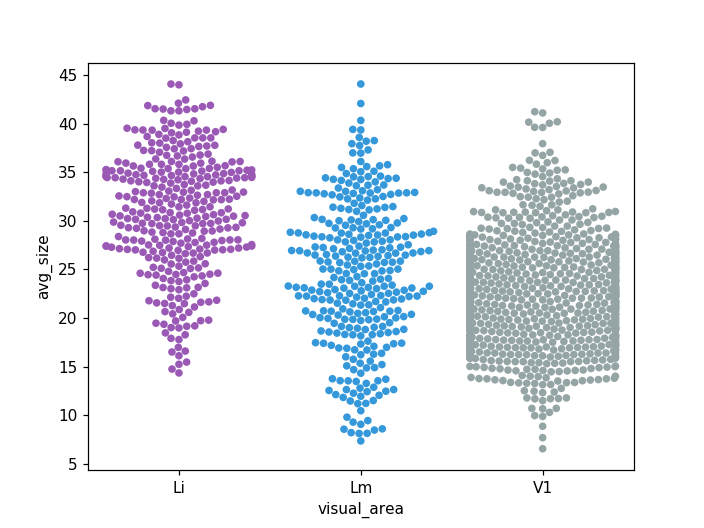

In [164]:
pl.figure()
sns.swarmplot(x="visual_area", y="avg_size", data=rfdf)

In [165]:
sorted(excluded_sessions, key=natural_keys)

['JC076-20190422',
 'JC076-20190501',
 'JC078-2019513',
 'JC078-20190426',
 'JC078-20190509',
 'JC080-20190506',
 'JC083-20190510',
 'JC083-20190511',
 'JC083-20190512',
 'JC083-20190517',
 'JC091-20190606',
 'JC091-20190607',
 'JC099-20190509']

In [166]:
rfdf

,r2,sigma_x,sigma_y,theta,x0,y0,cell,animalid,session,visual_area,fov,avg_size
0,0.814382,23.146798,13.394771,0.131838,6.947459,-8.639012,0.0,JC076,20190502,Li,FOV1_zoom2p0x,18.270785
1,0.684173,37.878427,29.035087,-0.425973,-29.804538,-2.607508,7.0,JC076,20190502,Li,FOV1_zoom2p0x,33.456757
2,0.547915,42.869814,25.073697,-3.139462,-25.042646,0.492693,11.0,JC076,20190502,Li,FOV1_zoom2p0x,33.971755
3,0.694613,41.777743,27.529382,0.277368,-23.260081,-2.007161,84.0,JC076,20190502,Li,FOV1_zoom2p0x,34.653563
4,0.553680,23.755476,17.985994,1.224352,-1.715291,15.132260,107.0,JC076,20190502,Li,FOV1_zoom2p0x,20.870735
5,0.555700,49.130250,21.382432,3.662978,-0.701245,23.751010,114.0,JC076,20190502,Li,FOV1_zoom2p0x,35.256341
6,0.798962,23.080949,49.025305,0.089750,2.689807,47.478206,120.0,JC076,20190502,Li,FOV1_zoom2p0x,36.053127
7,0.608521,26.647765,30.661356,1.342867,0.310076,18.084239,135.0,JC076,20190502,Li,FOV1_zoom2p0x,28.654560
8,0.612314,15.865567,12.826058,0.601666,-4.026763,23.330451,143.0,JC076,20190502,Li,FOV1_zoom2p0x,14.345812
9,0.828918,26.503840,44.212059,-1.521403,-5.222194,19.280016,169.0,JC076,20190502,Li,FOV1_zoom2p0x,35.357949


In [182]:
rfdf.groupby(['visual_area', 'animalid', 'session', 'fov'])['cell'].count()

visual_area  animalid  session   fov          
Li           JC076     20190502  FOV1_zoom2p0x     21
             JC090     20190605  FOV1_zoom2p0x     13
             JC091     20190602  FOV1_zoom2p0x     90
                       20190614  FOV1_zoom2p0x     97
             JC099     20190609  FOV1_zoom2p0x     44
                       20190612  FOV1_zoom2p0x     51
                       20190617  FOV1_zoom2p0x     17
Lm           JC076     20190423  FOV1_zoom2p0x     16
             JC078     20190430  FOV1_zoom2p0x     45
                       20190504  FOV1_zoom2p0x     15
                       20190513  FOV1_zoom2p0x     23
             JC080     20190602  FOV2_zoom2p0x     36
                       20190603  FOV1_zoom2p0x     58
             JC083     20190508  FOV1_zoom2p0x     70
             JC084     20190525  FOV1_zoom2p0x     42
             JC091     20190627  FOV1_zoom2p0x     12
V1           JC076     20190420  FOV1_zoom2p0x     48
             JC083     20190507  FO

In [167]:
rfdf.groupby(['visual_area', 'animalid', 'session', 'fov'])['cell'].count()

visual_area  animalid  session   fov          
Li           JC076     20190502  FOV1_zoom2p0x     21
             JC090     20190605  FOV1_zoom2p0x     13
             JC091     20190602  FOV1_zoom2p0x     90
                       20190614  FOV1_zoom2p0x     97
             JC099     20190609  FOV1_zoom2p0x     44
                       20190612  FOV1_zoom2p0x     51
                       20190617  FOV1_zoom2p0x     17
Lm           JC076     20190423  FOV1_zoom2p0x     16
             JC078     20190430  FOV1_zoom2p0x     45
                       20190504  FOV1_zoom2p0x     15
                       20190513  FOV1_zoom2p0x     23
             JC080     20190602  FOV2_zoom2p0x     36
                       20190603  FOV1_zoom2p0x     58
             JC083     20190508  FOV1_zoom2p0x     70
             JC084     20190525  FOV1_zoom2p0x     42
             JC091     20190627  FOV1_zoom2p0x     12
V1           JC076     20190420  FOV1_zoom2p0x     48
             JC083     20190507  FO

In [183]:
rfdf.groupby(['visual_area'])['cell'].count()

visual_area
Li    333
Lm    317
V1    912
Name: cell, dtype: int64

In [26]:
rfdf.groupby(['visual_area', 'animalid', 'session', 'fov'])['cell'].count()

visual_area  animalid  session   fov          
Li           JC076     20190502  FOV1_zoom2p0x     21
             JC090     20190605  FOV1_zoom2p0x     13
             JC091     20190602  FOV1_zoom2p0x    138
                       20190606  FOV1_zoom2p0x     48
                       20190607  FOV1_zoom2p0x     73
                       20190614  FOV1_zoom2p0x     97
             JC099     20190609  FOV1_zoom2p0x     44
                       20190612  FOV1_zoom2p0x     51
                       20190617  FOV1_zoom2p0x     17
Lm           JC076     20190423  FOV1_zoom2p0x     16
             JC078     20190426  FOV1_zoom2p0x     91
                       20190430  FOV1_zoom2p0x     45
                       20190504  FOV1_zoom2p0x     15
                       20190509  FOV1_zoom2p0x     14
                       20190513  FOV1_zoom2p0x     23
             JC080     20190506  FOV1_zoom2p0x     31
                       20190602  FOV2_zoom2p0x     36
                       20190603  FO

In [34]:
rfdf.groupby(['visual_area', 'animalid', 'session'])['cell'].count()

visual_area  animalid  session 
Li           JC076     20190502     21
             JC090     20190605     13
             JC091     20190602    138
                       20190606     48
                       20190607     73
                       20190614     97
             JC099     20190609     44
                       20190612     51
                       20190617     17
Lm           JC076     20190423     16
             JC078     20190426     91
                       20190430     45
                       20190504     15
                       20190509     14
                       20190513     23
             JC080     20190506     31
                       20190602     36
                       20190603     58
             JC083     20190508     70
                       20190512     55
                       20190517     22
             JC084     20190525     42
             JC091     20190627     12
V1           JC076     20190420     48
                       20190501 

In [27]:
rfdf.groupby(['visual_area'])['cell'].count()

visual_area
Li     502
Lm     530
V1    1277
Name: cell, dtype: int64

# Set color schemes by visual area

In [148]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

# Visualize general stats

In [184]:
rfstatsdir = os.path.join(rfdir, 'general-stats')
if not os.path.exists(rfstatsdir):
    os.makedirs(rfstatsdir)
print rfstatsdir

/n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff/general-stats


### 1. Average RF size

In [185]:
def compare_rf_size(df, cdf=False, ax=None, alpha=1):
    if ax is None:
        fig, ax = pl.subplots(figsize=(6,4))
        fig.patch.set_alpha(1)

    for visual_area in visual_areas:
        nrats = len(df[df['visual_area']==visual_area]['animalid'].unique())
        ncells_total = df[df['visual_area']==visual_area].shape[0]
        values = df[df['visual_area']==visual_area]['avg_size'].values
        weights = np.ones_like(values)/float(len(values))
        ax.hist(values, 
                cumulative=cdf,
                label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
                color=area_colors[visual_area],
                histtype='step', alpha=alpha, lw=3,
                normed=0, weights=weights)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('average size (deg)')
    if cdf:
        ax.set_ylabel('CDF')
    else:
        ax.set_ylabel('fraction')

<IPython.core.display.Javascript object>


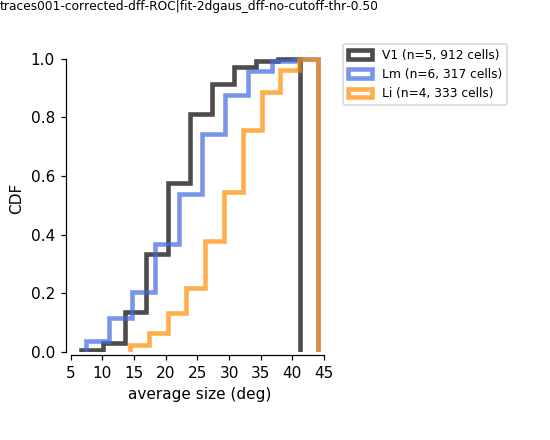

In [186]:
cdf = True
plot_type = 'cdf' if cdf else 'hist'

fig, ax = pl.subplots(figsize=(5,4))
fig.patch.set_alpha(1)
ax = compare_rf_size(rfdf, cdf=cdf, ax=ax, alpha=0.7)

pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(rfstatsdir, 'average-rf-size_no-repeats_%s.png' % plot_type))

In [200]:
reload(cc)

<module 'pipeline.python.retinotopy.convert_coords' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/convert_coords.py'>

# Compare cortical position vs. VF position

In [201]:
def get_fov_coordinates(animalid, session, fov, rffits):

    S = util.Session(animalid, session, fov)
    experiment_list = S.get_experiment_list()
    if 'rfs10' in experiment_list:
        S.get_experiment_data(experiment='rfs10')
        rf_exp_name = 'rfs10'
    else:
        S.get_experiment_data(experiment='rfs')
        rf_exp_name= 'rfs'
    
    masks, zimg = S.load_masks()
    roi_contours = cc.contours_from_masks(masks)
    # Convert to brain coords
    fov_pos_x, rf_xpos, xlim, fov_pos_y, rf_ypos, ylim = cc.get_roi_position_um(rffits, roi_contours, 
                                                                         rf_exp_name=rf_exp_name,
                                                                         convert_um=True)
    
    posdf = pd.DataFrame({'xpos_fov': fov_pos_y,
                          'xpos_rf': rf_xpos,
                          'ypos_fov': fov_pos_x,
                          'ypos_rf': rf_ypos,
                         'visual_area': [visual_area for _ in range(len(fov_pos_x))],
                         'animalid': [animalid for _ in range(len(fov_pos_x))],
                         'session': [session for _ in range(len(fov_pos_x))],
                         'fov': [fov for _ in range(len(fov_pos_x))]})
    return posdf


#### Create output subdir

In [188]:
retinodir = os.path.join(rfdir, 'retinotopic-organization')
if not os.path.exists(retinodir):
    os.makedirs(retinodir)
print("Saving retino comparisons to: %s" % retinodir)

Saving retino comparisons to: /n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff/retinotopic-organization


In [189]:
rfdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff'

In [194]:
rfdf

,r2,sigma_x,sigma_y,theta,x0,y0,cell,animalid,session,visual_area,fov,avg_size
0,0.814382,23.146798,13.394771,0.131838,6.947459,-8.639012,0.0,JC076,20190502,Li,FOV1_zoom2p0x,18.270785
1,0.684173,37.878427,29.035087,-0.425973,-29.804538,-2.607508,7.0,JC076,20190502,Li,FOV1_zoom2p0x,33.456757
2,0.547915,42.869814,25.073697,-3.139462,-25.042646,0.492693,11.0,JC076,20190502,Li,FOV1_zoom2p0x,33.971755
3,0.694613,41.777743,27.529382,0.277368,-23.260081,-2.007161,84.0,JC076,20190502,Li,FOV1_zoom2p0x,34.653563
4,0.553680,23.755476,17.985994,1.224352,-1.715291,15.132260,107.0,JC076,20190502,Li,FOV1_zoom2p0x,20.870735
5,0.555700,49.130250,21.382432,3.662978,-0.701245,23.751010,114.0,JC076,20190502,Li,FOV1_zoom2p0x,35.256341
6,0.798962,23.080949,49.025305,0.089750,2.689807,47.478206,120.0,JC076,20190502,Li,FOV1_zoom2p0x,36.053127
7,0.608521,26.647765,30.661356,1.342867,0.310076,18.084239,135.0,JC076,20190502,Li,FOV1_zoom2p0x,28.654560
8,0.612314,15.865567,12.826058,0.601666,-4.026763,23.330451,143.0,JC076,20190502,Li,FOV1_zoom2p0x,14.345812
9,0.828918,26.503840,44.212059,-1.521403,-5.222194,19.280016,169.0,JC076,20190502,Li,FOV1_zoom2p0x,35.357949


#### Load converted RF positions

In [ ]:
get_positions = False
pos_fpath = os.path.join(rfdir, 'rf_positions_no-repeats.pkl')

if os.path.exists(pos_fpath):
    print("Loading existing RF coord conversions...")
    try:
        with open(pos_fpath, 'rb') as f:
            aggr = pkl.load(f)
            posdf = aggr['posdf']
    except Exception as e:
        get_positions = True
else:
    get_positions = True
    
if get_positions:
    print("Calculating RF coord conversions...")
    pos_list = []
    for visual_area in visual_areas:
        d = rfdf[rfdf['visual_area']==visual_area]
        for (animalid, session, fov), g in d.groupby(['animalid', 'session', 'fov']):
            rffits = g.copy()
            rffits.index = g.index
            posdf = get_fov_coordinates(animalid, session, fov, rffits)
            pos_list.append(posdf)

    posdf = pd.concat(pos_list, axis=0).reset_index()
    with open(pos_fpath, 'wb') as f:
        aggr = {'posdf': posdf}
        pkl.dump(aggr, f, protocol=pkl.HIGHEST_PROTOCOL)

Calculating RF coord conversions...
[JC076] 20190420 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e280bf_traces001_113086_traces001_caa531_traces001_d04d75_traces001_5735eb/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
... ... loaded traces
Created 300 contours for rois.
[JC083] 20190507 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190507 | FOV1_zoom2p0x)
... Getting screen info
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC083|201905

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -238.1365301854446
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -241.5973938899258
STIM TYPE: gratings
**** File 9 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/gratings_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -45.94010416666708
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -268.78871777181735
Showing initial drift correction (quantile: 0.10)


... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -40.074829931972545
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -170.30199057731187
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -176.10100446428578
STIM TYPE: gratings
**** File 19 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/gratings_run2
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 12 extra frames...
... Last frame to align: 2923 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Exclu

*** Excluding: []
/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/gratings_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 5 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -54.08322411533459
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -199.59408771089625
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -195.3310990767045
STIM TYPE: gratings
**** File 29 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/gratings_run3
N tsecs: 2911
There are 462 total trials across all .tif files

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -44.378091872791856
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -207.18023989898984
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -208.59772727272718
STIM TYPE: gratings
**** File 38 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/gratings_run4
N tsecs: 2911
There are 252 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 4 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -49.64266304347825
Showing initial drift correction (quantile: 0.1

Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -53.26500732064426
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -187.93279384362
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -189.54144287109375
STIM TYPE: gratings
**** File 48 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/gratings_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -242.09421019900537
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -245.65189190764954
STIM TYPE: gratings
**** File 57 of 61 *****
*** Excluding: []
/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/gratings_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -47.432605905006255
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -256.35509918558574
Showing initial drift correction (quantile: 0.

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -373.50259232954545
STIM TYPE: gratings
**** File 3 of 66 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 2 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -87.22717913520978
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -326.51649039718995
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -320.03668212890625
STIM TYPE: gratings
**** File 4 of 66 *****
*** Exclu

In [196]:
g

,r2,sigma_x,sigma_y,theta,x0,y0,cell,animalid,session,visual_area,fov,avg_size
650,0.560729,26.660013,14.677006,0.480571,45.590696,5.655262,5.0,JC076,20190420,V1,FOV1_zoom2p0x,20.668509
651,0.700572,18.544881,27.457492,-1.213948,34.002847,1.460737,7.0,JC076,20190420,V1,FOV1_zoom2p0x,23.001187
652,0.662501,25.931098,13.671781,0.179837,40.360602,4.182264,24.0,JC076,20190420,V1,FOV1_zoom2p0x,19.801440
653,0.781057,33.063524,21.225100,0.532055,43.581691,2.775072,25.0,JC076,20190420,V1,FOV1_zoom2p0x,27.144312
654,0.714365,27.373139,17.750419,0.326742,43.078912,2.955575,26.0,JC076,20190420,V1,FOV1_zoom2p0x,22.561779
655,0.707094,27.160107,14.969679,0.362651,40.634818,1.694305,32.0,JC076,20190420,V1,FOV1_zoom2p0x,21.064893
656,0.517407,18.823079,15.031205,-2.974026,35.999623,2.910907,42.0,JC076,20190420,V1,FOV1_zoom2p0x,16.927142
657,0.692997,29.571789,16.540277,0.354880,42.819644,2.639498,48.0,JC076,20190420,V1,FOV1_zoom2p0x,23.056033
658,0.849391,13.501388,12.019555,-0.492124,32.207853,4.417421,49.0,JC076,20190420,V1,FOV1_zoom2p0x,12.760471
659,0.690849,30.600726,21.082328,0.598519,35.729461,3.134915,52.0,JC076,20190420,V1,FOV1_zoom2p0x,25.841527


In [59]:
posdf.head()

,index,animalid,fov,session,visual_area,xpos_fov,xpos_rf,ypos_fov,ypos_rf
0,5,JC076,FOV1_zoom2p0x,20190420,V1,41.969973,45.590696,273.349886,5.655262
1,7,JC076,FOV1_zoom2p0x,20190420,V1,267.081644,34.002847,125.092321,1.460737
2,24,JC076,FOV1_zoom2p0x,20190420,V1,129.725370,40.360602,356.744767,4.182264
3,25,JC076,FOV1_zoom2p0x,20190420,V1,120.186740,43.581691,403.075256,2.775072
4,26,JC076,FOV1_zoom2p0x,20190420,V1,146.894904,43.078912,379.910012,2.955575


##  Linear regression

In [60]:
from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

In [61]:
def fit_linear_regr(xvals, yvals, return_regr=False):
    regr = LinearRegression()
    if len(xvals.shape) == 1:
        xvals = np.array(xvals).reshape(-1, 1)
        yvals = np.array(yvals).reshape(-1, 1)
    else:
        xvals = np.array(xvals)
        yvals = np.array(yvals)
    regr.fit(xvals, yvals)
    fitv = regr.predict(xvals)
    if return_regr:
        return fitv.reshape(-1), regr
    else:
        return fitv.reshape(-1)

#### Cortical position vs. VF position by DATASET

In [62]:
# Create output subdir for visual area plots
curr_outdir = os.path.join(retinodir, 'sessions')
if not os.path.exists(curr_outdir):
    os.makedirs(curr_outdir)
print("Saving session plots to: %s" % curr_outdir)

Saving session plots to: /n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff/retinotopic-organization/sessions


In [65]:
# Set fit and plot params
el_color = 'blue'
az_color = 'red'
indep_var = 'fov'
dep_var = 'fov' if indep_var=='rf' else 'rf'

In [66]:
plot_azimuth = True

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


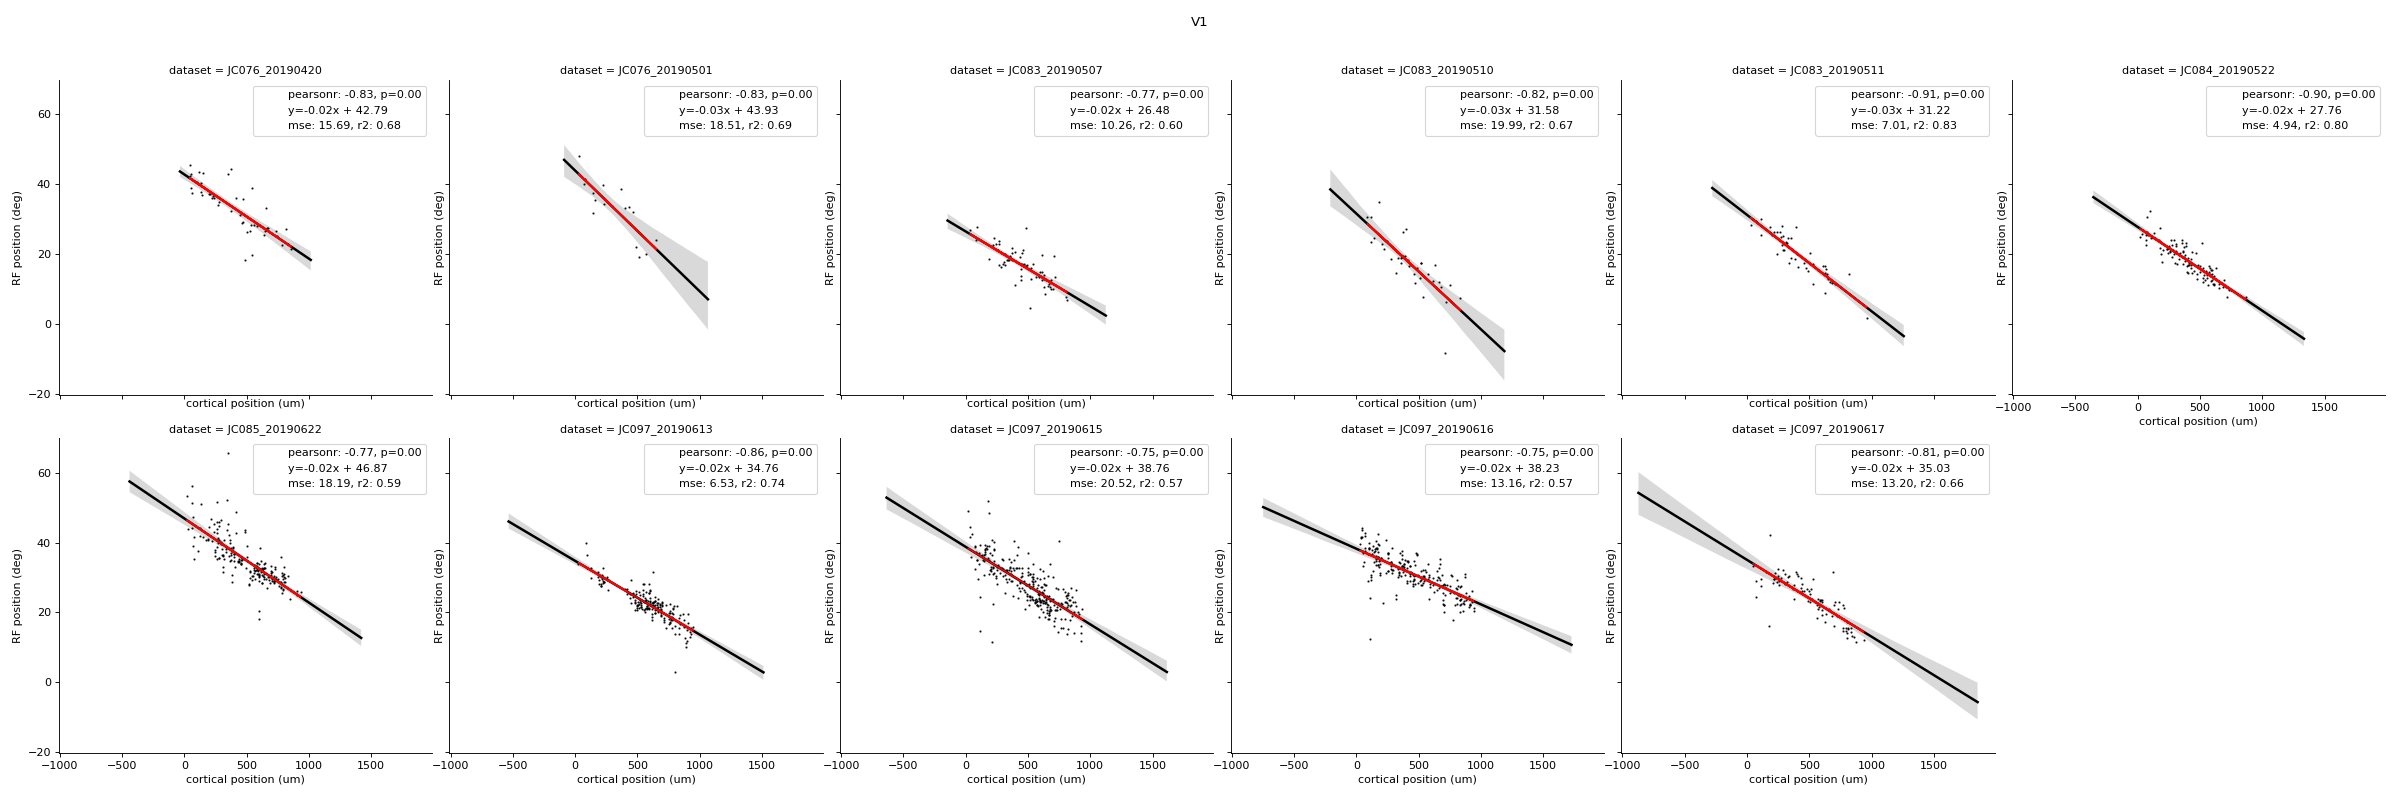

<IPython.core.display.Javascript object>


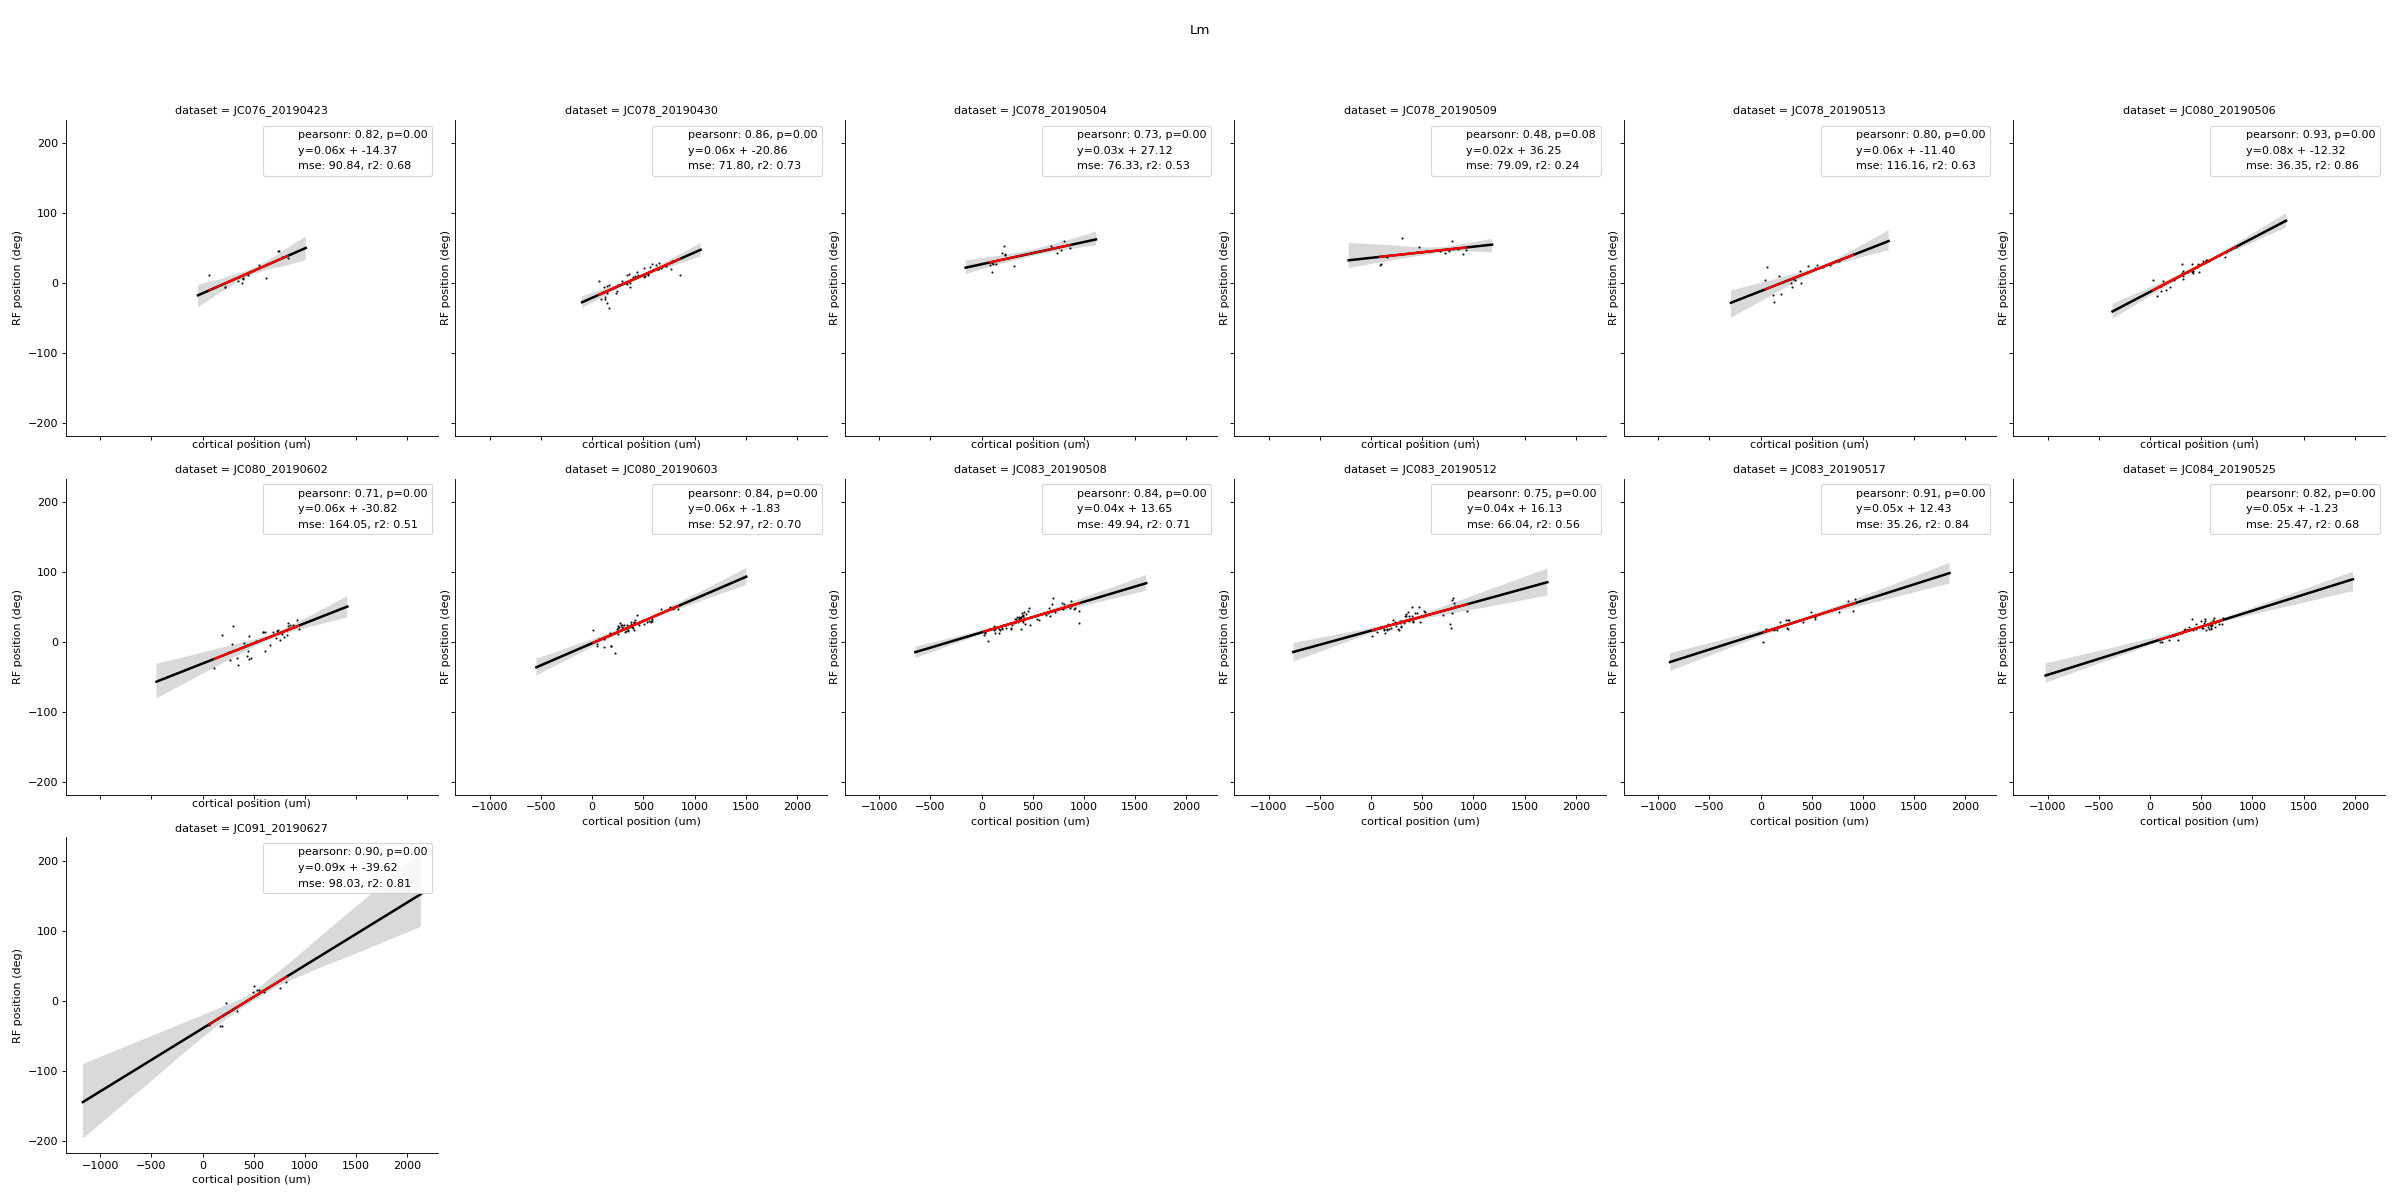

<IPython.core.display.Javascript object>


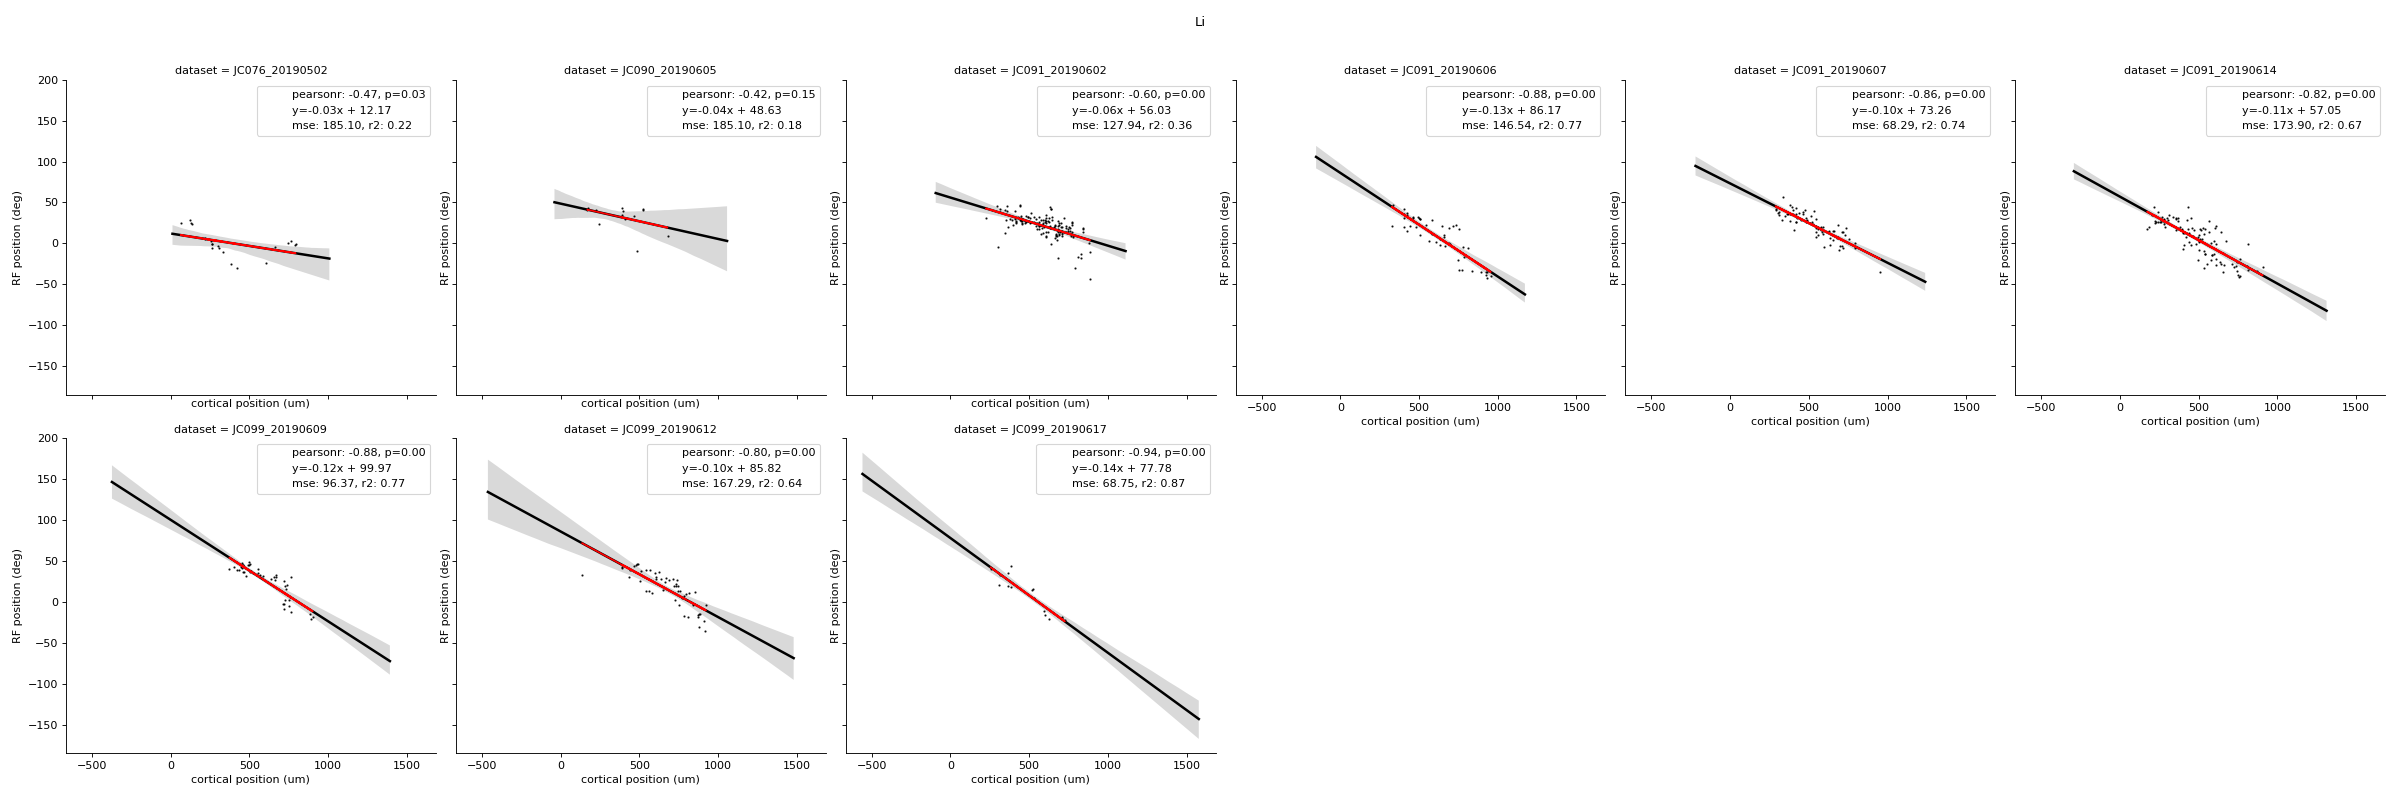

In [67]:

xlabel = 'cortical position (um)' if indep_var == 'fov' else 'RF position (deg)'
ylabel = 'RF position (deg)' if indep_var == 'fov' else 'cortical position (um)'

xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200

curr_color = az_color if plot_azimuth else el_color

axname = 'xpos' if plot_azimuth else 'ypos'

regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = posdf[posdf['visual_area']==visual_area]
    tmpd['dataset'] = ['%s_%s' % (a, s) for a, s, in zip(tmpd['animalid'], tmpd['session'])]

    # Plot regression w/ CI
    g = sns.lmplot('%s_%s' % (axname, indep_var), '%s_%s' % (axname, dep_var), data=tmpd, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)
    
    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = tmpd[tmpd['dataset']==curr_dset]['%s_%s' % (axname, indep_var)]
        yv = tmpd[tmpd['dataset']==curr_dset]['%s_%s' % (axname, dep_var)]
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Fit line
        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, curr_color)
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)
        
        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        #ax.set_xlim([xmin, xmax])
        #ax.set_ylim([ymin, ymax])

        regr_stats.append(pd.Series({'dataset': curr_dset,
                                   'mse': mse,
                                   'slope': float(regr.coef_),
                                   'intercept': float(regr.intercept_),
                                   'r2': r2,
                                     'pearsonr': p,
                                    'visual_area': visual_area}))

    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    figname = '%s-regr-on-%s_%s' % ('azimuth' if plot_azimuth else 'elevation', indep_var, visual_area)
    pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))


#### Calculate goodness of fit and aggregate by visual area

In [69]:
def get_regr_stats(xv, yv):
    fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
    mse = skmetrics.mean_squared_error(yv, fitv)
    r2 = skmetrics.r2_score(yv, fitv)
    residuals = yv - fitv
    evfit = pd.Series({#'residuals': yv-fitv,
                          'RMSE': np.sqrt(float(mse)),
                          'R2': float(r2),
                          'slope': float(regr.coef_),
                          'intercept': float(regr.intercept_),
                          'Exp-Var': float(skmetrics.explained_variance_score(yv, fitv)),
                          'MedAE': skmetrics.median_absolute_error(yv, fitv)})
    
    return evfit

In [72]:
def boxplot_visual_area(df, metric='slope', whichax=None, ax=None, area_colors=None):
    if ax is None:
        fig, ax = pl.subplots()
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
        
    if whichax == None:
        metricname = metric
    else:
        metricname = '%s_%s' % (metric, whichax)

    df[metricname] = df[metricname].astype(float)
        
    sns.boxplot(x='visual_area', y=metricname, data=df, ax=ax, palette=area_colors)
    sns.swarmplot(x='visual_area', y=metricname, data=df, color=".25", ax=ax)
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')       
    
    if metric in ['slope', 'pearsonr']:
        ax.axhline(y=0, linestyle=':', color='k')
        
    if metric == 'pearsonr':
        ax.set_ylim([-1, 1])
    elif metric in ['pearsonr-abs', 'R2']:
        ax.set_ylim([0, 1])
    elif metric == 'slope':
        maxv = df[metricname].abs().max()
        ax.set_ylim([-maxv, maxv])
    sns.despine(trim=True, offset=2, bottom=True, ax=ax)
    
    #ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
    return ax


In [73]:

dflist = []
for (visual_area, animalid, session, fov), g in posdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    tmpevs = []
    xv_az = g['xpos_%s' % indep_var]
    yv_az = g['xpos_%s' % dep_var]

    evfit = get_regr_stats(xv_az, yv_az)
    for c in evfit.index.tolist():
        evfit['%s_az' % c] = evfit.pop(c)
    tmpevs.append(evfit)
    
    xv_el = g['ypos_%s' % indep_var]
    yv_el = g['ypos_%s' % dep_var]
    evfit = get_regr_stats(xv_el, yv_el)
    for c in evfit.index.tolist():
        evfit['%s_el' % c] = evfit.pop(c)
    tmpevs.append(evfit)
    
    evdf = pd.concat(tmpevs, axis=0)
    evdf['dataset'] = '_'.join([animalid, session])
    evdf['visual_area'] = visual_area

    dflist.append(evdf)

retinostats = pd.concat(dflist, axis=1).T

In [74]:
retinostats.head()

,Exp-Var_az,MedAE_az,R2_az,RMSE_az,intercept_az,slope_az,Exp-Var_el,MedAE_el,R2_el,RMSE_el,intercept_el,slope_el,dataset,visual_area
0,0.216872,10.6906,0.216872,13.605,12.1651,-0.0303807,0.623921,2.93271,0.623921,7.41112,-8.17065,0.0332828,JC076_20190502,Li
1,0.177438,7.86615,0.177438,13.605,48.6301,-0.0430867,0.154092,3.01214,0.154092,6.83784,0.57856,-0.0179948,JC090_20190605,Li
2,0.356247,5.45908,0.356247,11.3109,56.0282,-0.0586956,0.0185052,5.61689,0.0185052,9.08093,-5.38922,-0.00507921,JC091_20190602,Li
3,0.769928,7.69374,0.769928,12.1054,86.17,-0.126504,0.0291094,6.52826,0.0291094,8.7944,-9.1818,0.00488823,JC091_20190606,Li
4,0.73767,5.41248,0.73767,8.26347,73.2623,-0.0968827,0.101516,6.09002,0.101516,8.80127,-13.5341,0.0107659,JC091_20190607,Li


In [75]:
retinostats['visual_area'].unique()

array(['Li', 'Lm', 'V1'], dtype=object)

#### Plot regression stats by visual area

In [76]:
common_metrics = ['visual_area', 'dataset']
regr_metrics = np.unique([m.split('_')[0] for m in retinostats.columns.tolist() if m not in common_metrics])
print regr_metrics

['Exp-Var' 'MedAE' 'R2' 'RMSE' 'intercept' 'slope']


In [77]:
# Get average of axes
for metric in regr_metrics:
    retinostats[metric] = np.abs(retinostats[['%s_az' % metric, '%s_el' % metric]]).mean(axis=1)



In [78]:
# curr_metrics = regr_metrics.copy()
# curr_metrics = np.append(curr_metrics, common_fields)
# avgmetrics = retinostats[curr_metrics]

exclude=['intercept']
curr_metrics = [m for m in regr_metrics if m not in exclude]


<IPython.core.display.Javascript object>


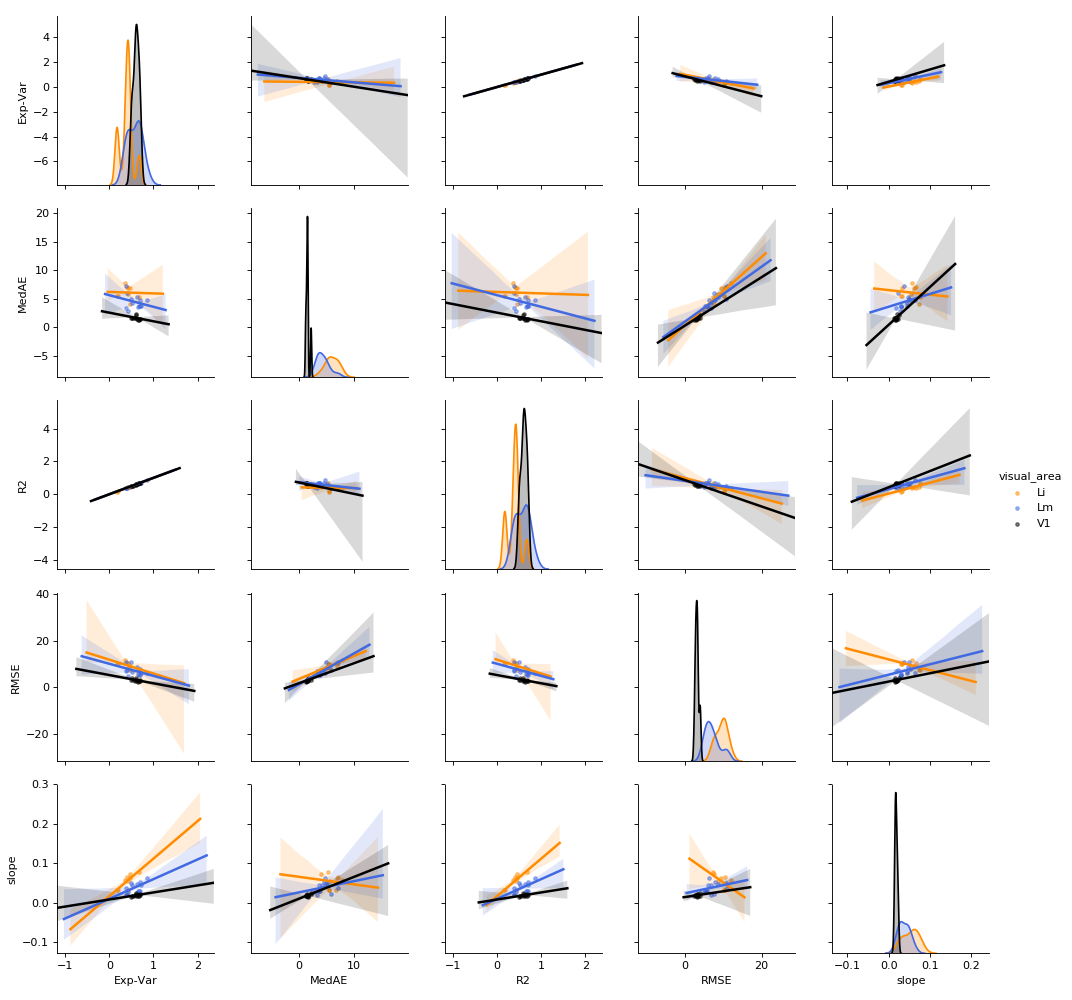

In [79]:
g= sns.pairplot(retinostats, vars=curr_metrics, hue='visual_area', palette=area_colors,
            kind='reg', plot_kws=dict(scatter_kws=dict(s=10, alpha=0.5, linewidth=1)),
            diag_kind='kde') #, diag_kws=dict(histtype='step', normed=False))
g.fig.patch.set_alpha(1)
pl.savefig(os.path.join(retinodir, 'regression-metrics_regr-on-%s.png' % indep_var))

#### Plot subset of summary stats

<IPython.core.display.Javascript object>


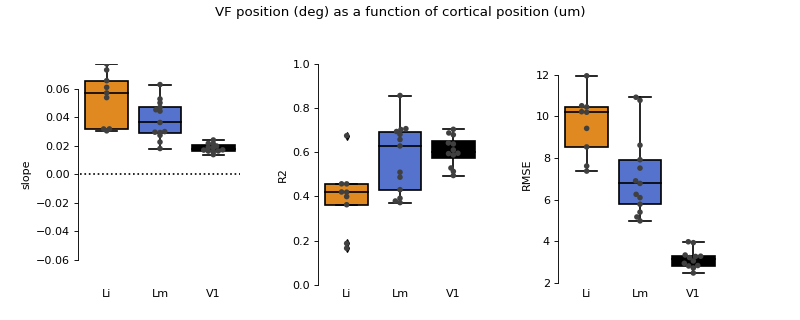

bothaxes_stats-regr-on-fov


In [80]:
plot_azimuth = None

if isinstance(plot_azimuth, bool):
    whichax = 'az' if plot_azimuth else 'el'
else:
    whichax=None

if indep_var == 'fov':
    figtitle = 'VF position (deg) as a function of cortical position (um)'
else:
    figtitle = 'cortical position (um) as a function of VF position (deg)'

fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(retinostats, metric='slope', whichax=whichax, ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(retinostats, metric='R2',  whichax=whichax, ax=axes[1], area_colors=area_colors)
ax3 = boxplot_visual_area(retinostats, metric='RMSE', whichax=whichax, ax=axes[2], area_colors=area_colors)
#ax4 = boxplot_visual_area(retinostats, metric='MedAE', whichax=whichax, ax=axes[3], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle(figtitle)

figname = '%s_stats-regr-on-%s' % ('bothaxes' if plot_azimuth is None else whichax, indep_var)
pl.savefig(os.path.join(retinodir, '%s.png' % figname))
print figname

#### Calculate residuals

In [81]:

def calculate_distance(df, indep_var='fov'):
    
    if indep_var=='fov':
        dep_var = 'rf'
    elif indep_var == 'rf':
        dep_var = 'fov'
    
    regr = LinearRegression()
    xv = np.array(df['xpos_%s' % indep_var]).reshape(-1, 1) 
    yv = np.array(df['xpos_%s' % dep_var]).reshape(-1, 1)
    regr.fit(xv, yv)
    fitv = regr.predict(xv)
    df['resid_az'] = yv - fitv

    mse_az = skmetrics.mean_squared_error(yv, fitv)
    r2_az = skmetrics.r2_score(yv, fitv)
    df['mse_az'] = [mse_az for _ in range(len(fitv))]
    df['r2_az'] = [r2_az for _ in range(len(fitv))]
    
    regr = LinearRegression()
    xv = np.array(df['ypos_%s' % indep_var]).reshape(-1, 1) 
    yv = np.array(df['ypos_%s' % dep_var]).reshape(-1, 1)
    regr.fit(xv, yv)
    fitv = regr.predict(xv)
    df['resid_el'] = yv - fitv
    
    mse_el = skmetrics.mean_squared_error(yv, fitv)
    r2_el = skmetrics.r2_score(yv, fitv) #, multioutput='variance_weighted')
    df['mse_el'] = [mse_el for _ in range(len(fitv))]
    df['r2_el'] = [r2_el for _ in range(len(fitv))]
    
    return df

#### Plot residuals by visual area

In [82]:
print indep_var

fov


In [231]:
pf = pd.concat([calculate_distance(g, indep_var=indep_var) 
                for k, g in posdf.groupby(['animalid', 'session', 'fov'])], axis=0)


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

<IPython.core.display.Javascript object>


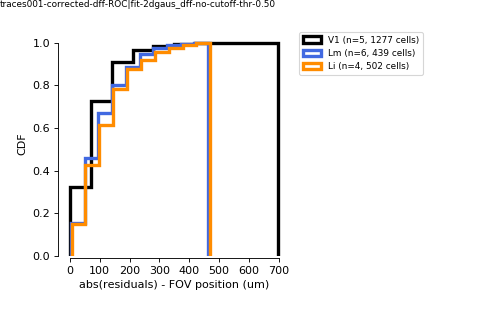

residuals_regr-on-rf_cdf


In [192]:

cdf = True

xlabel = 'abs(residuals) - RF positions (deg)' if indep_var=='fov' else 'abs(residuals) - FOV position (um)'
ylabel = 'CDF' if cdf else 'fraction'

fig, ax = pl.subplots(figsize=(6,4), sharey=True)
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(pf[pf['visual_area']==visual_area]['animalid'].unique())
    ncells_total = pf[pf['visual_area']==visual_area].shape[0]

    values = abs(pf[pf['visual_area']==visual_area][['resid_el', 'resid_az']]).mean(axis=1).values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
figname = 'residuals_regr-on-%s_%s' % (indep_var, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(retinodir, '%s.png' % figname))
print(figname)

#### Compare metrics (MSE v R2):

<IPython.core.display.Javascript object>


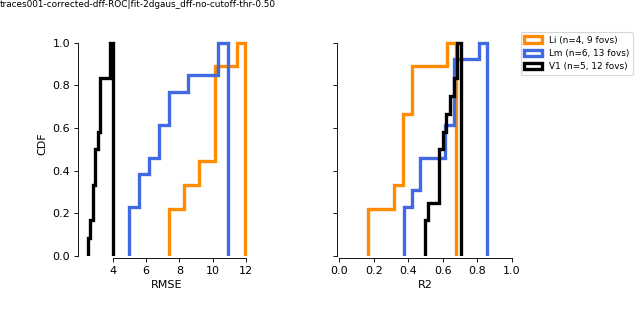

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [83]:
cdf = True
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in retinostats.groupby(['visual_area']):
    tmpd['animalid'] = [d.split('_')[0] for d in tmpd['dataset']]
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['dataset'].count()

    metric = 'RMSE'
    values = tmpd[['%s_el' % metric, '%s_az' % metric]].mean(axis=1).values
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel(metric)
    ax.set_ylabel('CDF' if cdf else 'fraction')
    
    metric = 'R2'
    values = tmpd[['%s_el' % metric, '%s_az' % metric]].mean(axis=1).values
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

sns.despine(ax=axes[0], trim=True, offset=2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(retinodir, 'RMSE-R2_regr-on-%s_%s.png' % (indep_var, 'cdf' if cdf else 'hist')))

#### Compare Azimuth v Elevation fits by Visual area

In [84]:
retinostats.head()

,Exp-Var_az,MedAE_az,R2_az,RMSE_az,intercept_az,slope_az,Exp-Var_el,MedAE_el,R2_el,RMSE_el,intercept_el,slope_el,dataset,visual_area,Exp-Var,MedAE,R2,RMSE,intercept,slope
0,0.216872,10.6906,0.216872,13.605,12.1651,-0.0303807,0.623921,2.93271,0.623921,7.41112,-8.17065,0.0332828,JC076_20190502,Li,0.420397,6.811673,0.420397,10.508065,10.167870,0.031832
1,0.177438,7.86615,0.177438,13.605,48.6301,-0.0430867,0.154092,3.01214,0.154092,6.83784,0.57856,-0.0179948,JC090_20190605,Li,0.165765,5.439145,0.165765,10.221427,24.604325,0.030541
2,0.356247,5.45908,0.356247,11.3109,56.0282,-0.0586956,0.0185052,5.61689,0.0185052,9.08093,-5.38922,-0.00507921,JC091_20190602,Li,0.187376,5.537984,0.187376,10.195898,30.708721,0.031887
3,0.769928,7.69374,0.769928,12.1054,86.17,-0.126504,0.0291094,6.52826,0.0291094,8.7944,-9.1818,0.00488823,JC091_20190606,Li,0.399519,7.111001,0.399519,10.449878,47.675911,0.065696
4,0.73767,5.41248,0.73767,8.26347,73.2623,-0.0968827,0.101516,6.09002,0.101516,8.80127,-13.5341,0.0107659,JC091_20190607,Li,0.419593,5.751254,0.419593,8.532372,43.398225,0.053824


<IPython.core.display.Javascript object>


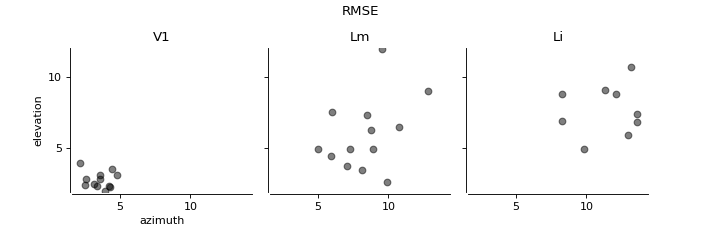

Text(0.5,0.98,u'RMSE')

In [86]:
metric = 'RMSE'
az_color = 'r'
el_color = 'b'

minv = min([0, tmpd['%s_az' % metric].min(), tmpd['%s_el' % metric].min()])
maxv = round(max([tmpd['%s_az' % metric].max(), tmpd['%s_el' % metric].max()]))

fig, axes = pl.subplots(1,3, figsize=(9,3), sharey=True, sharex=True) 
for ax, visual_area in zip(axes.flat, visual_areas):
    tmpd = retinostats[retinostats['visual_area']==visual_area]
    ax.scatter(np.array(tmpd['%s_az' % metric].values).astype(float), 
               np.array(tmpd['%s_el' % metric].values).astype(float), c='k', alpha=0.5)

    ax.set_title(visual_area)
    ax.axis('equal')
    #ax.set_aspect('equal') #, 'box')
    #ax.set(xlim=(minv, maxv), ylim=(minv, maxv))
    #sns.despine(ax=ax, trim=False, offset=2)
    #ticks = [round(i, 2) for i in np.linspace(minv, maxv, 4)]
    #ax.set_xticks(ticks)

ticks = ax.get_xticks() if ax.get_xticks()[-1] > ax.get_yticks()[-1] else ax.get_yticks()
for ax in axes.flat:
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.axis('equal')
axes[0].set_xlabel('azimuth')
axes[0].set_ylabel('elevation')

sns.despine(trim=False, offset=2)
#axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(wspace=0.1, top=0.8, left=0.1, right=0.9, bottom=0.2)
fig.suptitle(metric)


# Pairwise distances

In [87]:
from scipy.spatial.distance import pdist
#dists = skmetrics.pairwise.euclidean_distances(tmpd, Y=None) #, metric='euclidean')

#### Create output dir

In [88]:
pairwisedir = os.path.join(rfdir, 'pairwise-distances')
if not os.path.exists(pairwisedir):
    os.makedirs(pairwisedir)
print("Saving pairwise-distance analysis to: %s" % pairwisedir)

Saving pairwise-distance analysis to: /n/coxfs01/julianarhee/aggregate-visual-areas/rfs/fit-2dgaus_dff-no-cutoff/pairwise-distances


#### Look at PW distances of by dataset

In [92]:
# Create subdir
curr_sessiondir = os.path.join(pairwisedir, 'sessions')
if not os.path.exists(curr_sessiondir):
    os.makedirs(curr_sessiondir)

In [90]:
pf = pd.concat([calculate_distance(g, indep_var=indep_var) 
                for k, g in posdf.groupby(['animalid', 'session', 'fov'])], axis=0)


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

# Plot PW distance regression for each dataset for each visual area

<IPython.core.display.Javascript object>


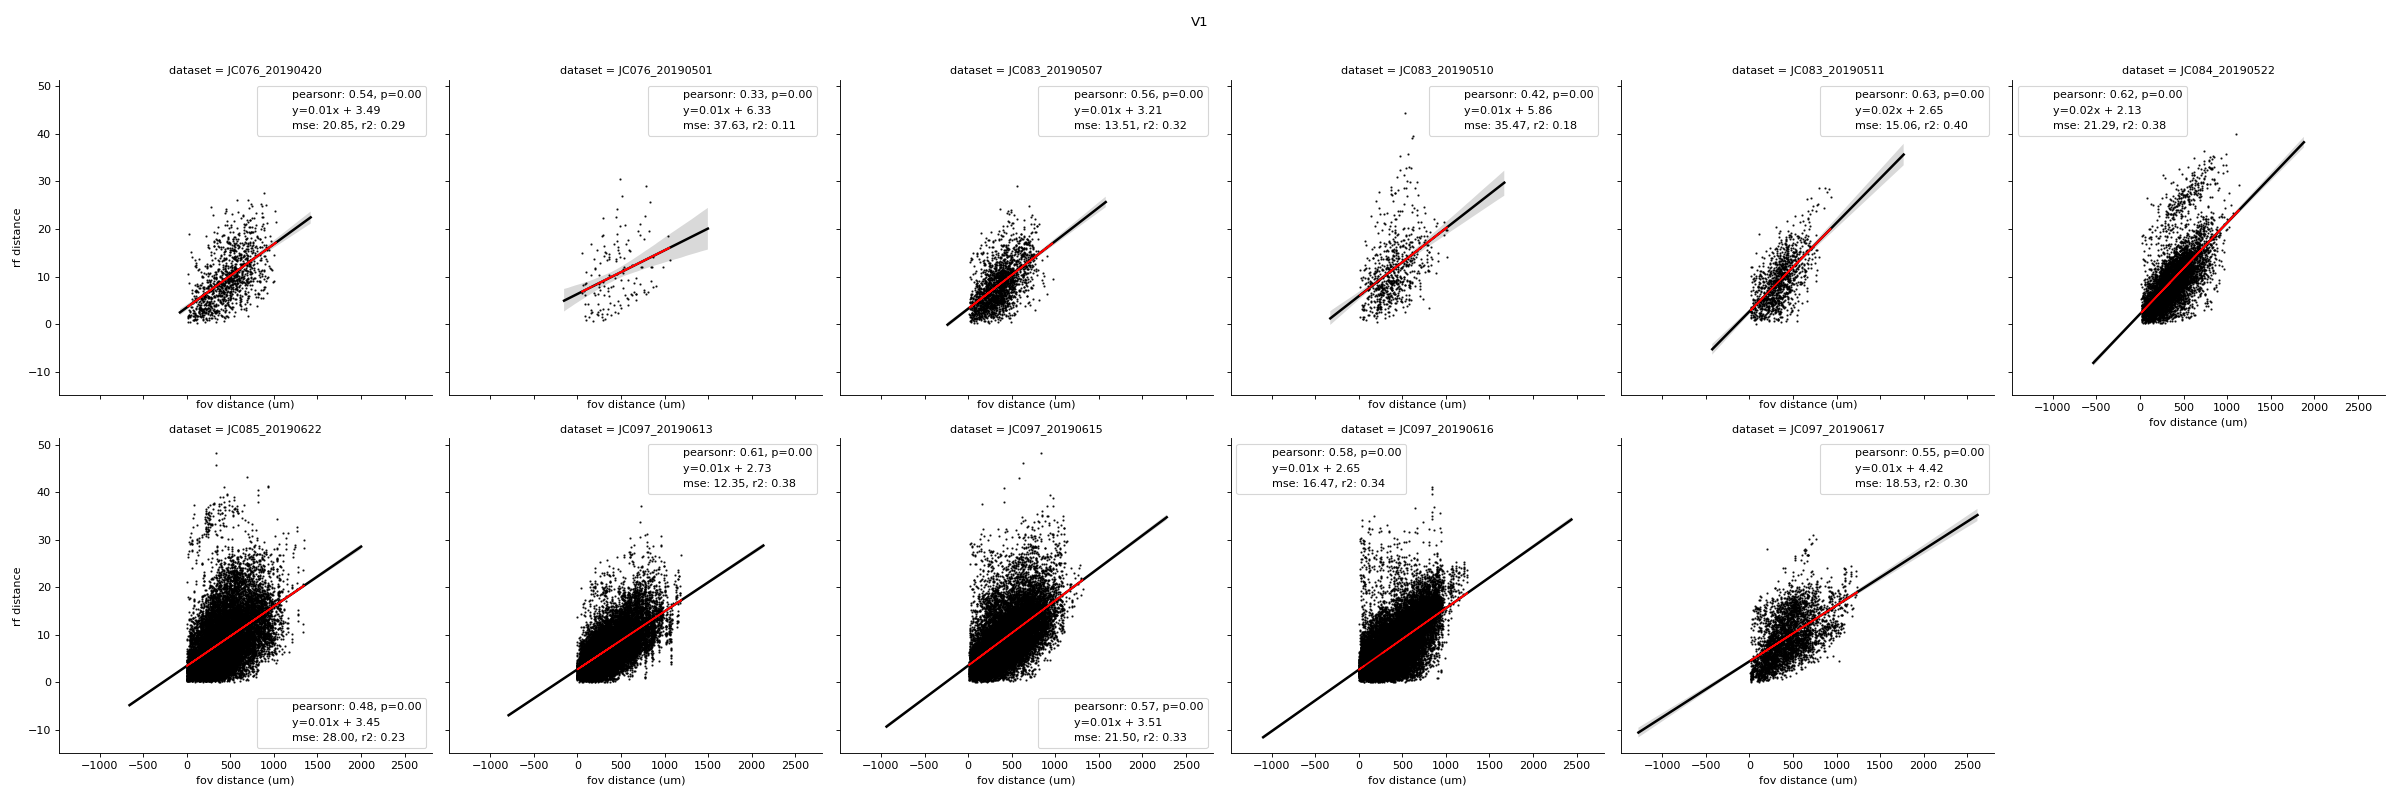

<IPython.core.display.Javascript object>


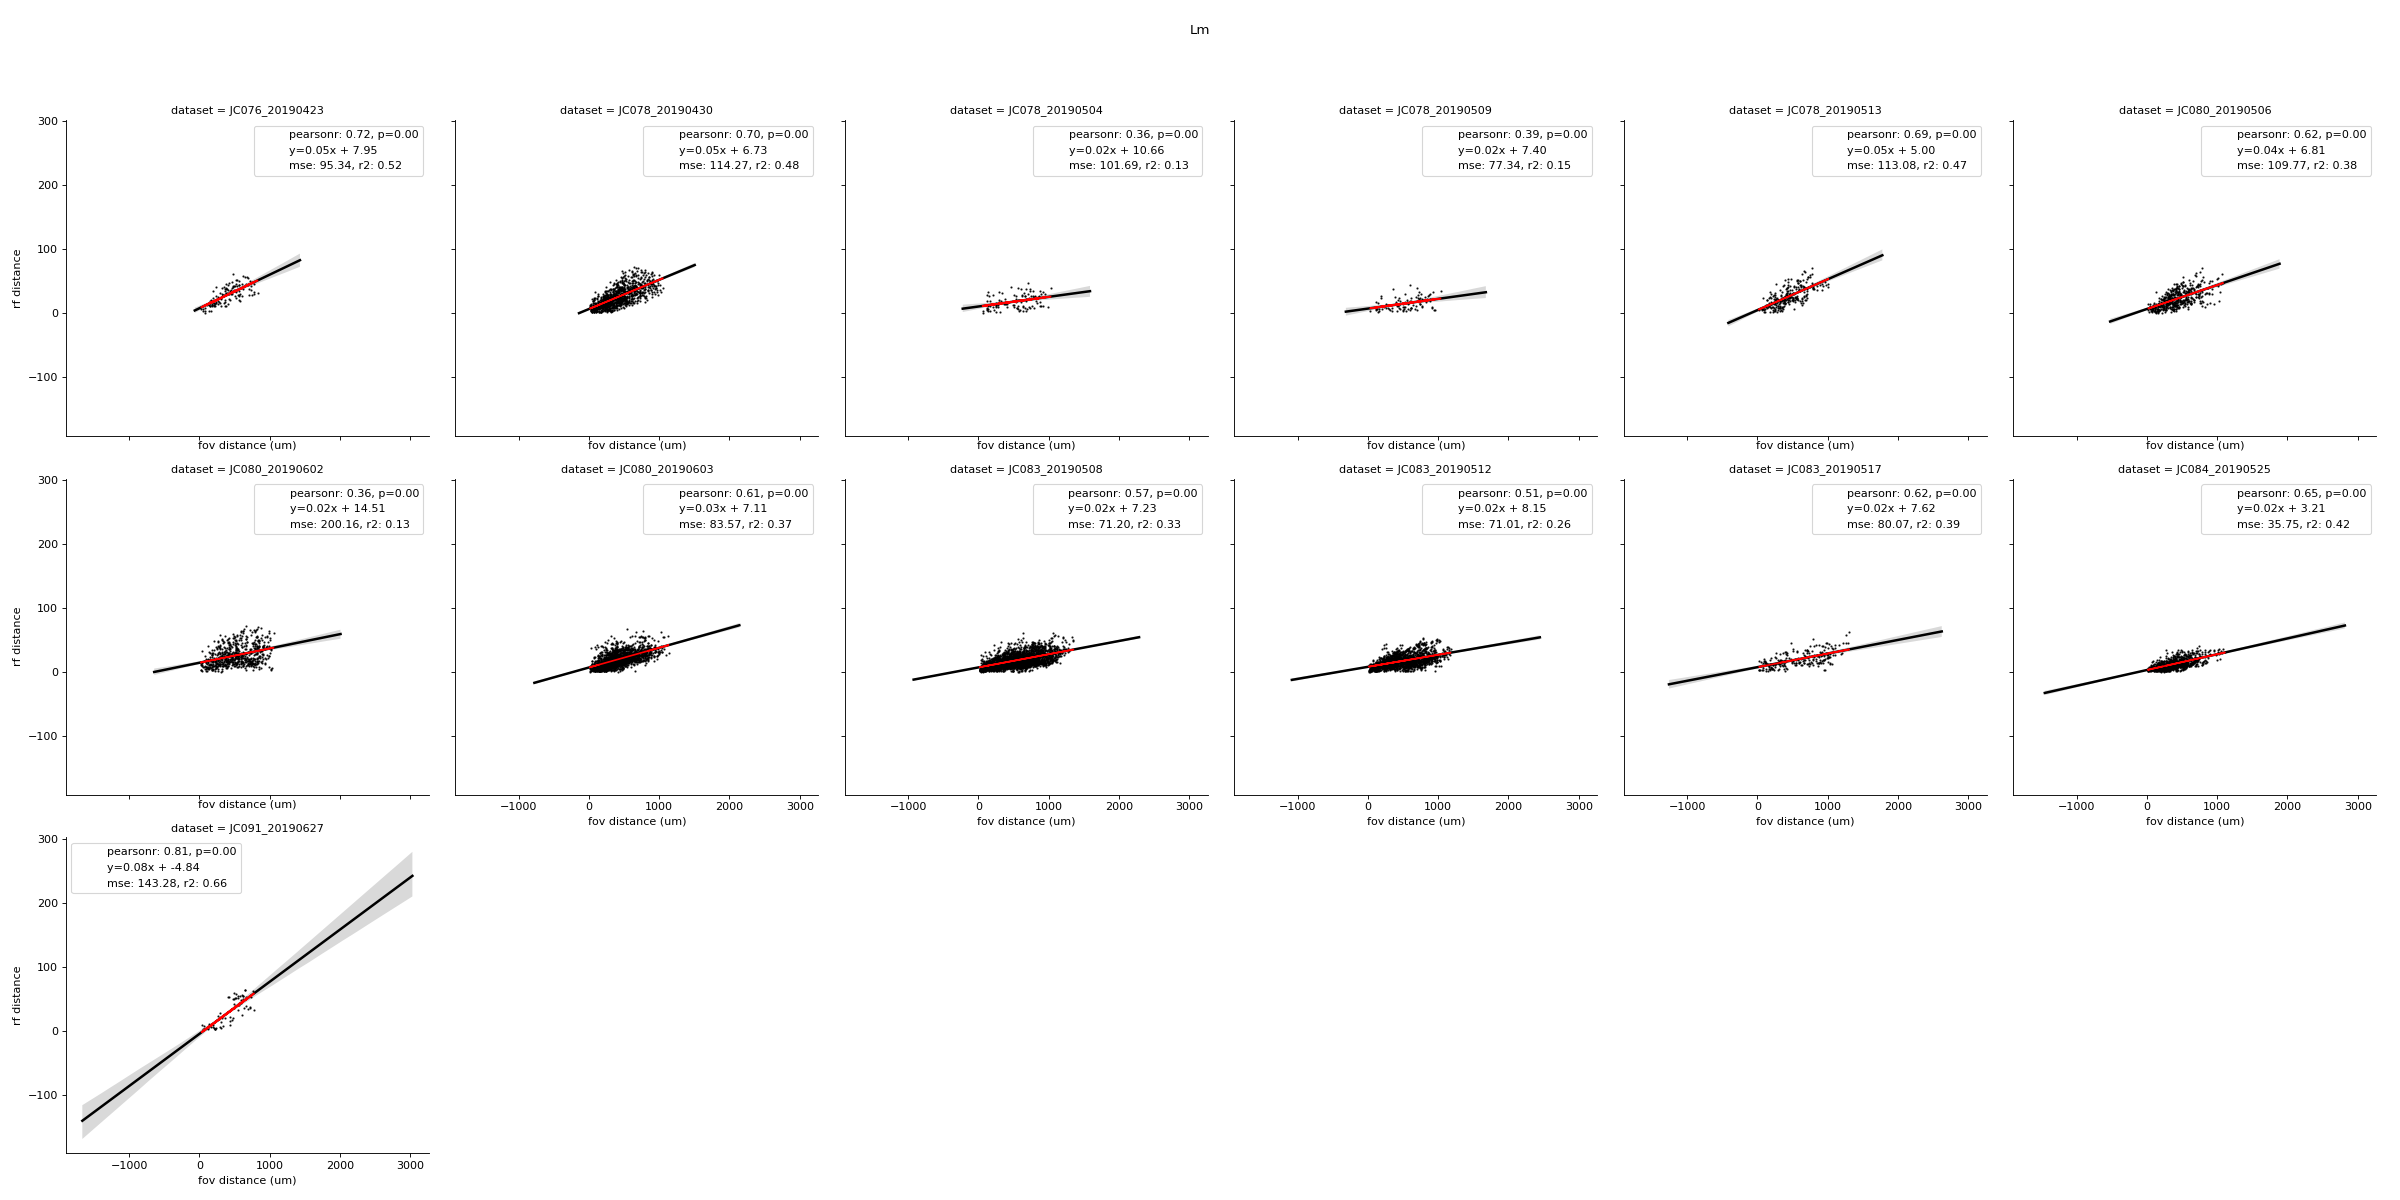

<IPython.core.display.Javascript object>


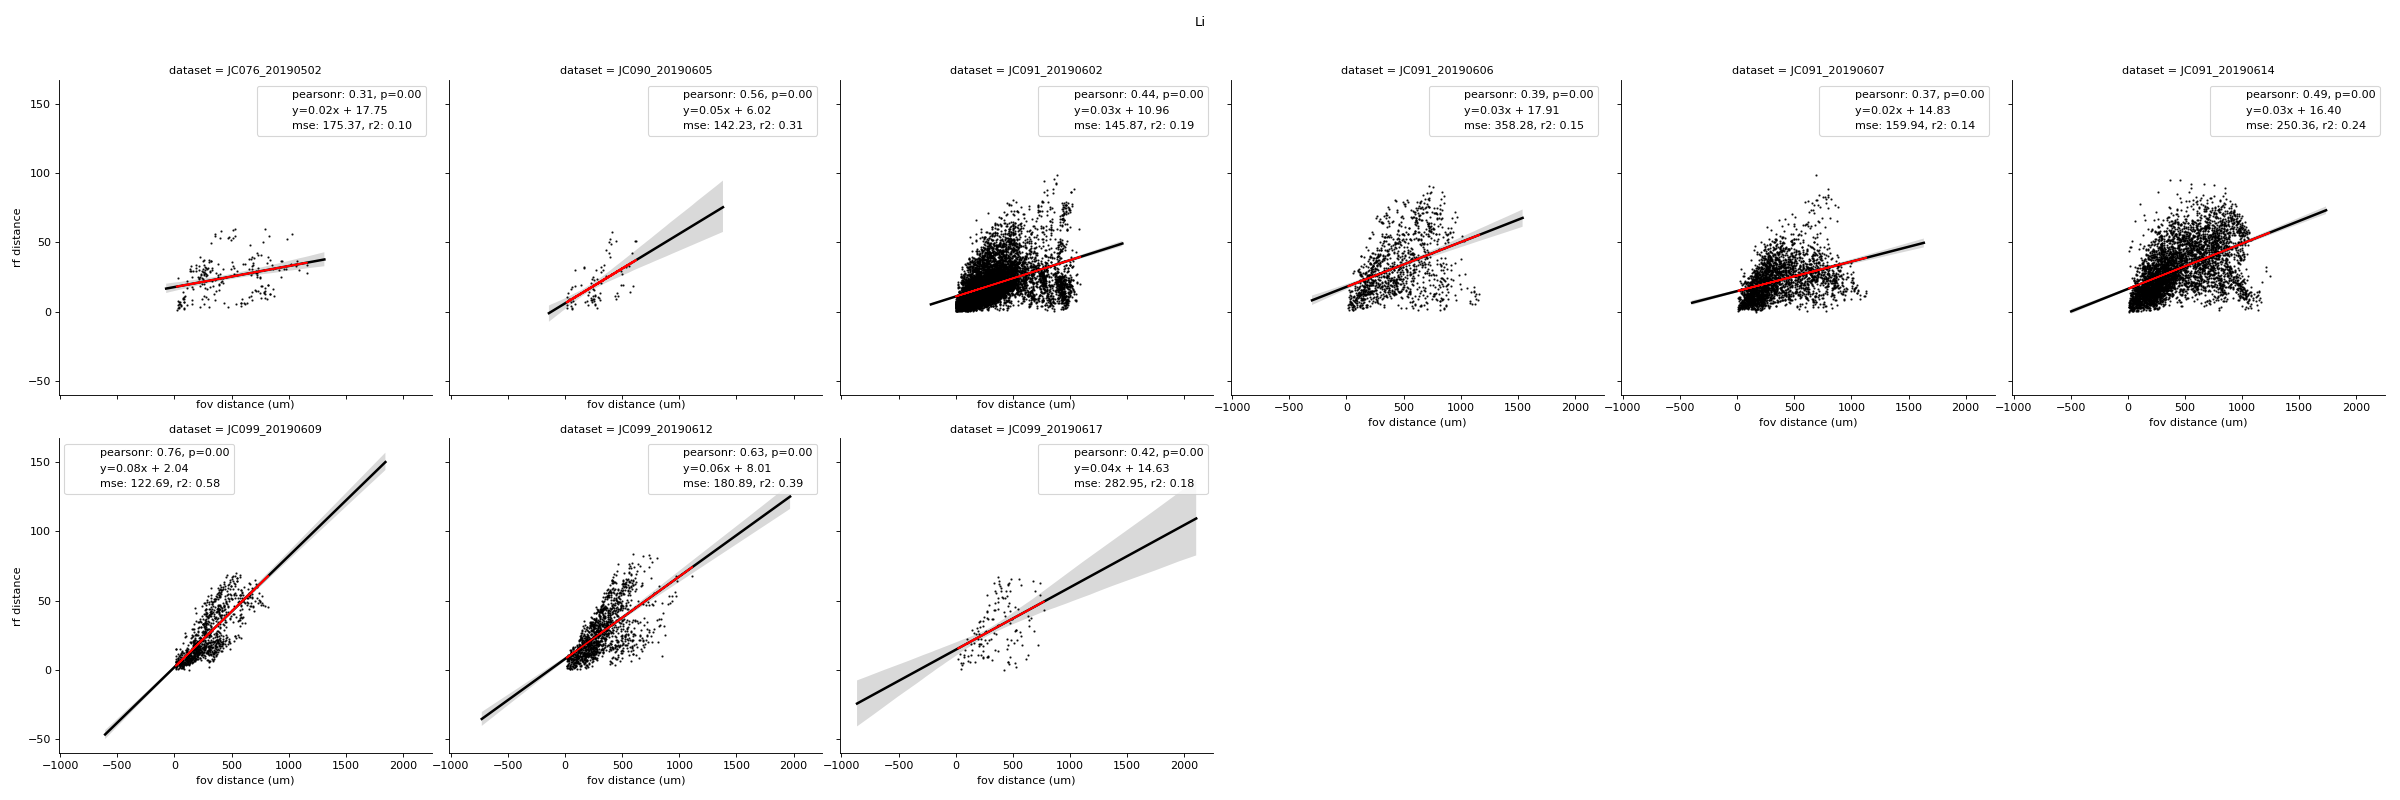

In [95]:
dep_var = 'rf' if indep_var=='fov' else 'fov'

# regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = pf[pf['visual_area']==visual_area]

    # Get all pairwise distances for each fov:
    tmpd_list = []
    for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
        cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
        rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
        tmpd = pd.DataFrame({'%s distance' % indep_var: cdists,
                            '%s distance' % dep_var: rdists,
                            'dataset': ['%s_%s' % (animalid, session) for _ in range(len(cdists))]})
        tmpd_list.append(tmpd)
    pw = pd.concat(tmpd_list, axis=0)

    # Plot regression w/ CI
    g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)

    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = pw[pw['dataset']==curr_dset]['%s distance' % indep_var]
        yv = pw[pw['dataset']==curr_dset]['%s distance' % dep_var]
        #ax.set_ylim([0, 120])
        unit = 'um' if indep_var=='fov' else 'deg'
        ax.set_xlabel('%s distance (%s)' % (indep_var, unit))

        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, 'r')
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)

        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        
#         regr_stats.append(pd.Series({'dataset': curr_dset,
#                                    'RMSE': np.sqrt(mse),
#                                    'slope': float(regr.coef_),
#                                    'intercept': float(regr.intercept_),
#                                    'R2': r2,
#                                     'visual_area': visual_area}))


    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(curr_sessiondir, 'regr-on-%s_%s.png' % (visual_area, indep_var)))


In [94]:
# reginfo = pd.concat(regr_stats, axis=1).T
# reginfo.head()

,R2,RMSE,dataset,intercept,slope,visual_area
0,0.291849,4.5666,JC076_20190420,3.49435,0.0133151,V1
1,0.110722,6.13418,JC076_20190501,6.32593,0.00917705,V1
2,0.317121,3.67584,JC083_20190507,3.21438,0.0141987,V1
3,0.177895,5.95603,JC083_20190510,5.859,0.0142868,V1
4,0.39773,3.88048,JC083_20190511,2.64958,0.0186305,V1


In [96]:
del reginfo

In [106]:

pwstats = []
for (visual_area, animalid, session, fov), g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    # Get all pairwise distances for current fov:
    cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
    rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
    # Get linear fit:
    fitdist, regr = fit_linear_regr(cdists, rdists, return_regr=True)
    mse = skmetrics.mean_squared_error(rdists, fitdist)
    r2 = skmetrics.r2_score(rdists, fitdist)
    res = pd.Series({'visual_area': visual_area,
                         'animalid': animalid,
                         'session': session,
                         'fov': fov,
                         'RMSE': np.sqrt(mse),
                         'R2': r2,
                         'slope': float(regr.coef_),
                         'intercept': float(regr.intercept_),
                         'dataset': '_'.join([animalid, session, fov])})
    pwstats.append(res)

pwstats = pd.concat(pwstats, axis=1).T


In [107]:
pwstats.head()

,R2,RMSE,animalid,dataset,fov,intercept,session,slope,visual_area
0,0.0953611,13.2428,JC076,JC076_20190502_FOV1_zoom2p0x,FOV1_zoom2p0x,17.7525,20190502,0.0151595,Li
1,0.31371,11.9261,JC090,JC090_20190605_FOV1_zoom2p0x,FOV1_zoom2p0x,6.01845,20190605,0.0501515,Li
2,0.193885,12.0777,JC091,JC091_20190602_FOV1_zoom2p0x,FOV1_zoom2p0x,10.9644,20190602,0.0261875,Li
3,0.154185,18.9284,JC091,JC091_20190606_FOV1_zoom2p0x,FOV1_zoom2p0x,17.9075,20190606,0.0322362,Li
4,0.139255,12.6467,JC091,JC091_20190607_FOV1_zoom2p0x,FOV1_zoom2p0x,14.832,20190607,0.0213036,Li


<IPython.core.display.Javascript object>


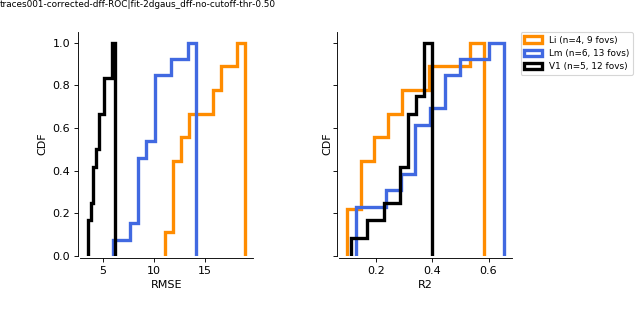

In [108]:
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in pwstats.groupby(['visual_area']):
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    values = tmpd['RMSE'].values.astype(float)
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel('RMSE')
    sns.despine(ax=ax, offset=2)
    ax.set_ylabel('CDF')
    
    
    values = tmpd['R2'].values.astype(float)
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, offset=2)
    ax.set_xlabel('R2')
    ax.set_ylabel('CDF')
    #ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(pairwisedir, 'pairwise-distances_RMSE-R2_cdf_regr-on-%s.png' % indep_var))


# Look at slope / intercept

<IPython.core.display.Javascript object>


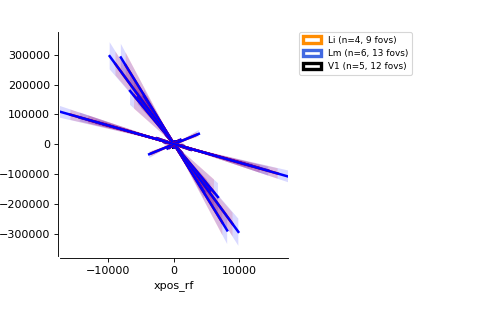

In [111]:
use_slope = True
fig, ax = pl.subplots(figsize=(6,4))

fig.patch.set_alpha(1)
for visual_area, tmpd in pwstats.groupby(['visual_area']):
    if use_slope:
        values = [s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'deg. vis. angle / cortical dist (um)'
        else:
            xlabel = 'cortical dist (um) / deg vis. angle'
    else:
        values = [1./s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'cortical dist (um) / deg vis. angle'
        else:
            xlabel = 'deg. vis. angle / cortical dist (um)'
    
    #dset_names = g['dataset'].unique()
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #ax.set_xticks([round(v, 1) for v in np.linspace(0, .1, 8)])
    #ax.set_xticklabels([round(v, 2) for v in np.linspace(0, .1, 8)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    sns.despine(trim=False, offset=2, ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

pl.savefig(os.path.join(pairwisedir, 'slopes_regr-on-%s_cdf.png' % indep_var))

<IPython.core.display.Javascript object>


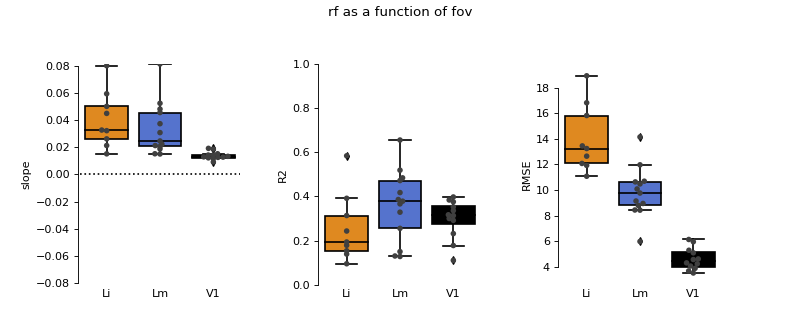

In [112]:
fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(pwstats, metric='slope', ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(pwstats, metric='R2', ax=axes[1], area_colors=area_colors)

ax3 = boxplot_visual_area(pwstats, metric='RMSE', ax=axes[2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'stats-regr-on-%s.png' % indep_var))

In [113]:
posdf.head()

,index,animalid,fov,session,visual_area,xpos_fov,xpos_rf,ypos_fov,ypos_rf
0,5,JC076,FOV1_zoom2p0x,20190420,V1,41.969973,45.590696,273.349886,5.655262
1,7,JC076,FOV1_zoom2p0x,20190420,V1,267.081644,34.002847,125.092321,1.460737
2,24,JC076,FOV1_zoom2p0x,20190420,V1,129.725370,40.360602,356.744767,4.182264
3,25,JC076,FOV1_zoom2p0x,20190420,V1,120.186740,43.581691,403.075256,2.775072
4,26,JC076,FOV1_zoom2p0x,20190420,V1,146.894904,43.078912,379.910012,2.955575


<IPython.core.display.Javascript object>


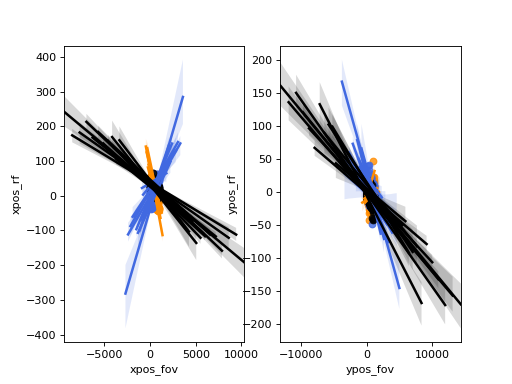

In [120]:
fig, axes = pl.subplots(1, 2)


for (visual_area, animalid, session, fov), tmpd in posdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.regplot('xpos_fov', 'xpos_rf', data=tmpd, ax=axes[0], color=area_colors[visual_area])
    sns.regplot('ypos_fov', 'ypos_rf', data=tmpd, ax=axes[1], color=area_colors[visual_area])


# Plot Center of mass for each FOV

In [199]:
CoMs = {}
screeninfo = {}
for (visual_area, animalid, session, fov), tmpd in rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    S = util.Session(animalid, session, fov)
    xpos, ypos = S.get_stimulus_coordinates()
    CoMs['%s_%s' % (animalid, session)] = (xpos, ypos) #[(xpos, ypos) for _ in range(tmpd.shape[0])])
    screenleft, screenright = S.screen['linminW'], S.screen['linmaxW']
    screenbottom, screentop = S.screen['linminH'], S.screen['linmaxH']
    screenaspect = S.screen['resolution'][0] / S.screen['resolution'][1]
    screeninfo['%s_%s' % (animalid, session)] = (screenleft, screenright, screenbottom, screentop, screenaspect) #for _ in range(tmpd.shape[0])])
    

[JC076] 20190502 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
[JC076|20190502] No experiment exists for: gratings
Stimuli presented at coords: (-5, 8)
[JC090] 20190605 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC090|20190605|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: com

... Getting screen info
... [JC080|20190506|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
[JC080|20190506] No experiment exists for: gratings
Stimuli presented at coords: (15, 8)
[JC080] 20190602 - FOV2_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
[JC080|20190602] No experiment exists for: blobs
[JC080|20190602] No experiment exists for: gratings
[JC080] 20190603 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC080|20190603|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC080|20190603|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings


... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (25, 5)
[JC097] 20190615 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
[JC097|20190615] No experiment exists for: blobs
[JC097|20190615] No experiment exists for: gratings
[JC097] 20190615 - FOV2_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
[JC097|20190615] No experiment exists for: blobs
[JC097|20190615] No experiment exists for: gratings
[JC097] 20190616 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC097|20190616|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC097|20190616|FOV1_zoom2p0x] creating grati

In [204]:


rfdf['CoM-x'] = [CoMs['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

rfdf['CoM-y'] = [CoMs['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenleft'] = [screeninfo['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenright'] = [screeninfo['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenbottom'] = [screeninfo['%s_%s' % (animalid, session)][2] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screentop'] = [screeninfo['%s_%s' % (animalid, session)][3] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenaspect'] = [screeninfo['%s_%s' % (animalid, session)][4] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

In [205]:
rfdf[((rfdf['animalid']=='JC084') & (rfdf['session']=='20190522'))]

,r2,sigma_x,sigma_y,theta,x0,y0,cell,animalid,session,visual_area,fov,avg_size,CoM-x,CoM-y,screenleft,screenright,screenbottom,screentop,screenaspect
0,0.734225,15.872766,23.564779,1.533098,24.776422,-11.469018,0.0,JC084,20190522,V1,FOV1_zoom2p0x,19.718773,20.0,-8.0,-58.7792,58.7792,-33.6615,33.6615,1
1,0.520136,16.516020,19.051182,-0.523212,32.432005,-11.544950,2.0,JC084,20190522,V1,FOV1_zoom2p0x,17.783601,20.0,-8.0,-58.7792,58.7792,-33.6615,33.6615,1
2,0.552829,18.949260,27.004408,-1.426131,17.836423,-12.234272,5.0,JC084,20190522,V1,FOV1_zoom2p0x,22.976834,20.0,-8.0,-58.7792,58.7792,-33.6615,33.6615,1
3,0.852096,23.878438,19.566025,-0.027895,24.116823,-11.728018,9.0,JC084,20190522,V1,FOV1_zoom2p0x,21.722232,20.0,-8.0,-58.7792,58.7792,-33.6615,33.6615,1
4,0.869807,21.945404,16.465211,0.250786,21.851019,-11.102363,11.0,JC084,20190522,V1,FOV1_zoom2p0x,19.205308,20.0,-8.0,-58.7792,58.7792,-33.6615,33.6615,1
5,0.749326,24.060205,17.826767,-0.540785,21.079350,-12.622418,12.0,JC084,20190522,V1,FOV1_zoom2p0x,20.943486,20.0,-8.0,-58.7792,58.7792,-33.6615,33.6615,1
6,0.855683,30.551514,22.742899,-0.194002,24.359459,-15.700910,17.0,JC084,20190522,V1,FOV1_zoom2p0x,26.647206,20.0,-8.0,-58.7792,58.7792,-33.6615,33.6615,1
7,0.696656,27.990076,23.843953,0.069130,25.972457,-13.935280,18.0,JC084,20190522,V1,FOV1_zoom2p0x,25.917014,20.0,-8.0,-58.7792,58.7792,-33.6615,33.6615,1
8,0.768487,21.792108,20.778926,0.133244,24.595777,-15.828255,19.0,JC084,20190522,V1,FOV1_zoom2p0x,21.285517,20.0,-8.0,-58.7792,58.7792,-33.6615,33.6615,1
9,0.647991,19.231749,23.597969,7.482864,24.647061,-14.644582,20.0,JC084,20190522,V1,FOV1_zoom2p0x,21.414859,20.0,-8.0,-58.7792,58.7792,-33.6615,33.6615,1


In [173]:
assert len(rfdf['screenleft'].unique())==1
assert len(rfdf['screenright'].unique())==1
assert len(rfdf['screentop'].unique())==1
assert len(rfdf['screenbottom'].unique())==1

In [170]:
screenleft = float(rfdf['screenleft'].unique())
screenright = float(rfdf['screenright'].unique())
screenbottom = float(rfdf['screenbottom'].unique())
screentop = float(rfdf['screentop'].unique())

In [247]:
all_cell_counts = rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']).count()['r2'].values
max_ncells = all_cell_counts.max()

ncells_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in all_cell_counts]
#ncells_alphas

[0.09502262443438914,
 0.058823529411764705,
 0.6244343891402715,
 0.2171945701357466,
 0.33031674208144796,
 0.43891402714932126,
 0.19909502262443438,
 0.23076923076923078,
 0.07692307692307693,
 0.07239819004524888,
 0.4117647058823529,
 0.20361990950226244,
 0.06787330316742081,
 0.06334841628959276,
 0.10407239819004525,
 0.14027149321266968,
 0.16289592760180996,
 0.26244343891402716,
 0.3167420814479638,
 0.248868778280543,
 0.09954751131221719,
 0.19004524886877827,
 0.05429864253393665,
 0.2171945701357466,
 0.07692307692307693,
 0.2986425339366516,
 0.17194570135746606,
 0.2171945701357466,
 0.502262443438914,
 0.8823529411764706,
 0.8190045248868778,
 0.6470588235294118,
 0.5610859728506787,
 1.0,
 0.38461538461538464]

In [250]:
import matplotlib.colors as mplc

In [255]:
[mplc.to_rgba(area_colors[visual_area], alpha=c) for c in cell_alphas]

[(1.0, 0.5490196078431373, 0.0, 0.09502262443438914),
 (1.0, 0.5490196078431373, 0.0, 0.058823529411764705),
 (1.0, 0.5490196078431373, 0.0, 0.6244343891402715),
 (1.0, 0.5490196078431373, 0.0, 0.2171945701357466),
 (1.0, 0.5490196078431373, 0.0, 0.33031674208144796),
 (1.0, 0.5490196078431373, 0.0, 0.43891402714932126),
 (1.0, 0.5490196078431373, 0.0, 0.19909502262443438),
 (1.0, 0.5490196078431373, 0.0, 0.23076923076923078),
 (1.0, 0.5490196078431373, 0.0, 0.07692307692307693)]

<IPython.core.display.Javascript object>


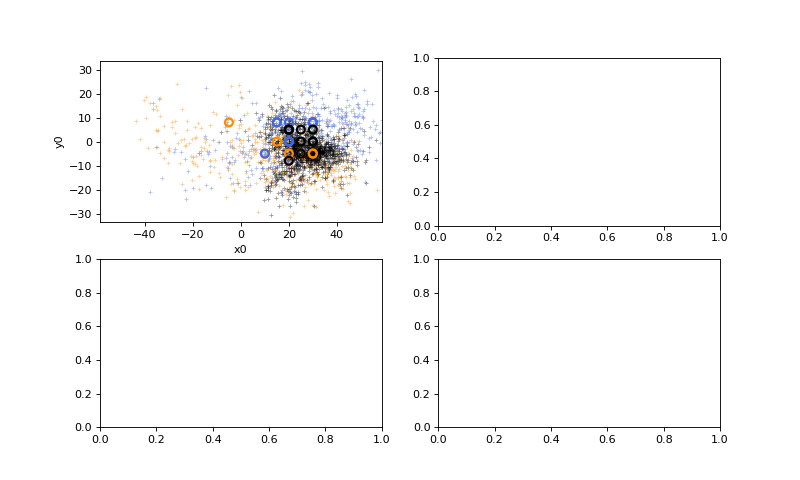

In [303]:
n_cells = []

fig, axes = pl.subplots(2, 2, figsize=(10,6))
ax = axes[0,0]
for (visual_area, animalid, session, fov), tmpd in rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.scatterplot('x0', 'y0', data=tmpd, ax=ax, color=area_colors[visual_area],
                   s=10, marker='+', alpha=0.4, edgecolor=area_colors[visual_area])
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)

    n_cells.append(tmpd.shape[0])

ax = axes[0,0]
for visual_area, tmpd in rfdf.groupby(['visual_area']):
    xcoms = [float(g['CoM-x'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ycoms = [float(g['CoM-y'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ncells = np.array([g.shape[0] for k, g in tmpd.groupby(['animalid', 'session', 'fov'])])
    cell_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in ncells]

    rgba_colors = [mplc.to_rgba(area_colors[visual_area], alpha=c/4.) for c in cell_alphas]
    
    ax.scatter(xcoms, ycoms, s=50, lw=2, edgecolors=area_colors[visual_area], alpha=1, facecolor='none') #c=rgba_colors, 
    #ax.scatter(xcoms, ycoms, s=ncells, c=rgba_colors)

    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)


In [232]:
ncells

[48, 17, 66, 38, 48, 111, 195, 181, 143, 124, 221, 85]